# SharePoint und Graph API Authentifizierungsbeispiele in Python

In diesem Beitrag zeigen wir **Python-Codebeispiele** für verschiedene Authentifizierungsmethoden, um Daten aus einer SharePoint-Liste auszulesen. Wir betrachten sowohl die **SharePoint REST API** (direkter Aufruf der SharePoint-Endpoints) als auch die **Microsoft Graph API** (moderne API für Office 365 Dienste einschließlich SharePoint). Alle Beispiele lesen ihre Zugangsdaten aus einer zentralen Konfigurationsdatei und schreiben die abgerufenen Listeneinträge in einen Pandas **DataFrame**. Dabei behandeln wir sowohl Legacy-Authentifizierungsmethoden (ältere Verfahren, teils nicht mehr unterstützt) als auch moderne Authentifizierungsverfahren. Paging wird in allen Beispielen berücksichtigt, sodass _alle_ Listeneinträge (alle Felder) geladen werden, auch wenn die Liste sehr groß ist.  

  

**Hinweis:** Einige der gezeigten Legacy-Methoden funktionieren in der Praxis nicht mehr in SharePoint Online bzw. mit der Graph API, was im Text jeweils erläutert wird. Moderne Cloud-Umgebungen erfordern in der Regel **OAuth-basierte** Verfahren (Azure AD Tokens). Legacy-Authentifizierungen wie **WS-Trust**, **Forms Based Auth (FBA)** oder **Basic Auth** sind entweder unsicher oder wurden bereits deaktiviert \[[learn.microsoft.com](https://learn.microsoft.com/en-us/sharepoint/technical-reference/basic-auth-is-being-deprecated#:~:text=Summary%3A%20Basic%20authentication%20is%20currently,from%20SharePoint%20Server%20Subscription%20Edition)\]. Diese zeigen wir der Vollständigkeit halber und um zu erklären, warum sie nicht mehr empfohlen sind.

## Inhaltsverzeichnis

0 | Vorbereitung: Konfiguration mit Zugangsdaten  
1 | SharePoint REST API  
1.1 | Legacy-Authentifizierung (SharePoint REST)  
1.1.1 | WS-Trust (Active Authentication mit SAML Token)  
1.1.2 | Forms-Based Authentication (FBA)  
1.1.3 | Basic Authentication  
1.2 | Moderne Authentifizierung (SharePoint REST)  
1.2.1 | Delegierte Berechtigungen  
1.2.1.1 | Device Code Flow (MSAL)  
1.2.2 | App-Only (Client Credentials)  
1.2.2.1 | Mit Client Secret  
1.2.2.2 | Mit Zertifikat

2 | Microsoft Graph API  
2.1 | Legacy-Authentifizierung (Graph; in der Praxis nicht nutzbar)  
2.1.1 | WS-Trust  
2.1.2 | Forms-Based Authentication (FBA)  
2.1.3 | Basic Authentication  
2.2 | Moderne Authentifizierung (Graph)  
2.2.1 | Delegierte Berechtigungen  
2.2.1.1 | Device Code Flow (MSAL, z. B. Scope `Sites.Read.All`)  
2.2.2 | App-Only (Client Credentials)  
2.2.2.1 | Mit Client Secret  
2.2.2.2 | Mit Zertifikat

3 | Gemeinsame Aspekte  
3.1 | Paging (`__next` bei SharePoint REST, `@odata.nextLink` bei Graph)  
3.2 | Alle Felder laden (keine `$select`\-Einschränkung)  
3.3 | Output in Pandas DataFrame  
3.4 | Fehlerbilder & Troubleshooting (401/403, Audience/Scopes, Consent, Sites.Selected)  
3.5 | Sicherheit & Least Privilege (Admin Consent, Sites.Selected, Secrets vs. Zertifikate)

4 | Zusammenfassung & Best Practices

# 0 | Vorbereitung: Konfigurationsdatei mit Zugangsdaten

Alle Scripts nutzen eine JSON-Konfigurationsdatei (z.B. `config.json`), um sensible Daten nicht im Code zu hinterlegen. Die Datei hat etwa folgenden Aufbau:

In [ ]:
{
  "azuread": {
    "tenant_id": "<Ihr Azure AD Tenant ID>",
    "client_id": "<Ihre Azure AD App Client ID>",
    "client_secret": "<Ihr Azure AD App Client Secret>",
    "cert_path": "<Pfad zu Ihrem Zertifikat.pem (falls benötigt)>",
    "cert_thumbprint": "<Thumbprint des Zertifikats (falls benötigt)>"
  },
  "sharepoint": {
    "username": "<Ihr SharePoint-Benutzername>",
    "password": "<Ihr SharePoint-Passwort>"
  }
}

Jedes Skript lädt diese Konfiguration und extrahiert die benötigten Werte:

In [ ]:
import json
config_path = r"C:\python\Scripts\config.json"
with open(config_path, "r", encoding="utf-8") as f:
    config = json.load(f)

TENANT_ID     = config["azuread"]["tenant_id"]
CLIENT_ID     = config["azuread"]["client_id"]
CLIENT_SECRET = config["azuread"]["client_secret"]

SHAREPOINT_USERNAME = config["sharepoint"]["username"]
SHAREPOINT_PASSWORD = config["sharepoint"]["password"]

Zusätzlich definieren wir zwei Variablen für die **Ziel-Website** und die **Zielliste** in SharePoint, die in allen Beispielen gleich bleiben. Ersetzen Sie diese durch Ihre tatsächliche Site-URL und den Listennamen:

In [ ]:
SITE_URL  = "https://<IhreDomain>.sharepoint.com/sites/<IhrSeitenname>"
LIST_NAME = "<Name Ihrer Liste>"

Um auch die SharePoint Listen in der Config-Datei zu speichern, empfiehlt sich <span style="color: var(--vscode-foreground);">&nbsp;die Konfiguration als </span> **Array gleichartiger Einträge** <span style="color: var(--vscode-foreground);"> zu speichern (</span>`sharepoint_lists`<span style="color: var(--vscode-foreground);">), jeweils mit </span> `base_url`<span style="color: var(--vscode-foreground);">, </span> `site_path` <span style="color: var(--vscode-foreground);"> und </span> `list_title`<span style="color: var(--vscode-foreground);">. Dieses Modell ist </span> **idiomatisches JSON** <span style="color: var(--vscode-foreground);"> und schafft eine klare, maschinen- wie menschenlesbare Struktur: Jede Liste ist ein eigenes Objekt mit einem kleinen, selbsterklärenden Datenvertrag. Dadurch wird Iteration in jedem Tech-Stack trivial (Python, Node, PowerShell, CI/CD), weil man ohne Sonderlogik schlicht über das Array laufen kann. Gleichzeitig ist die </span> **Reihenfolge definiert**<span style="color: var(--vscode-foreground);">, was für Pipelines, Prioritäten oder UI-Darstellung wichtig sein kann.</span>

Für Governance und Wartung spieltdiese ihre Stärken besonders aus. Mit **JSON-Schema** lässt sich das Array präzise validieren (Pflichtfelder, Muster, erlaubte Werte), Fehler fallen früh auf und Deployments werden robuster. Pro Eintrag können problemlos **Metadaten** ergänzt werden (z. B. `key`, `enabled`, Standardsfilter, Ziel-SQL-Tabelle, Throttling), ohne die übrige Struktur zu berühren. Das macht die Konfiguration **skalierbar**: neue Listen hinzufügen, einzelne deaktivieren, Reihenfolgen ändern – alles ohne Seiteneffekte.

Auch im Betrieb überzeugt das Modell: In **Versionsverwaltung** sind Diffs klein und nachvollziehbar (nur betroffene Array-Elemente ändern sich). **Environment-Overlays** (DEV/TEST/PROD) lassen sich elegant mergen, weil viele Tools Arrays als Sammlungen erwarten. Referenzen auf einzelne Listen können stabil über einen eigenen `key` erfolgen, unabhängig von Positionen im Array. Kurz: Variante B liefert eine **klare, validierbare und erweiterbare Konfigurationsbasis**, die technische Einfachheit (Iteration, Parsing) mit professionellen Anforderungen an Wartbarkeit, Governance und Automatisierung vereint.

In [ ]:
{
  "azuread": {
    "tenant_id": "<Ihr Azure AD Tenant ID>",
    "client_id": "<Ihre Azure AD App Client ID>",
    "client_secret": "<Ihr Azure AD App Client Secret>",
    "cert_path": "<Pfad zu Ihrem Zertifikat.pem (falls benötigt)>",
    "cert_thumbprint": "<Thumbprint des Zertifikats (falls benötigt)>"
  },
  "sharepoint": {
    "username": "<Ihr SharePoint-Benutzername>",
    "password": "<Ihr SharePoint-Passwort>"
  },
  "sharepoint_lists": [
    {
      "key": "XXXX",
      "base_url": "https://abc.sharepoint.com",
      "site_path": "/sites/DataAnalytics/DataMaintenance",
      "list_title": "XXXXX"
    }
    /* ,{ ... weitere Listen ... } */
  ]
}


In [ ]:
import json
from pathlib import Path
from urllib.parse import urlparse, quote

# ------------------------------------------------------------
# Config laden
# ------------------------------------------------------------
CONFIG_PATH = Path(r"C:\python\Scripts\config.json")

def load_config(path: Path) -> dict:
    with path.open("r", encoding="utf-8") as f:
        return json.load(f)

cfg = load_config(CONFIG_PATH)

# ------------------------------------------------------------
# Hilfsfunktionen für sharepoint_lists 
# ------------------------------------------------------------
def list_entries(config: dict) -> list[dict]:
    return config.get("sharepoint_lists", []) or []

def get_list_by_key(config: dict, key: str) -> dict | None:
    return next((e for e in list_entries(config) if e.get("key") == key), None)

def get_list_by_title(config: dict, list_title: str) -> dict | None:
    return next((e for e in list_entries(config) if e.get("list_title") == list_title), None)

def derive_urls(entry: dict) -> dict:
    """
    Liefert abgeleitete URLs/Parameter für REST (_api) und Graph.
    Gibt Keys zurück: base_url, site_path, site_url, host, list_title,
                      list_server_relative_url, rest_items_url, graph_items_url
    """
    base_url  = (entry.get("base_url") or "").rstrip("/")
    site_path = "/" + (entry.get("site_path") or "").lstrip("/").rstrip("/")
    list_title = entry.get("list_title") or ""
    if not base_url or not site_path or not list_title:
        raise ValueError("Ungültiger Listeneintrag: base_url, site_path und list_title sind Pflichtfelder.")

    site_url = f"{base_url}{site_path}"
    host     = urlparse(base_url).netloc

    # stabiler REST-Pfad via GetList('<serverrelativer Pfad>')
    list_server_relative_url = f"{site_path}/Lists/{list_title}"

    rest_items_url = f"{site_url}/_api/web/GetList('{quote(list_server_relative_url)}')/Items"

    # Graph-Endpoint (inkl. Felder)
    graph_items_url = (
        "https://graph.microsoft.com/v1.0/"
        f"sites/{host}:/{site_path.lstrip('/')}:/lists/{quote(list_title)}/items?$expand=fields"
    )

    return {
        "base_url": base_url,
        "site_path": site_path,
        "site_url": site_url,
        "host": host,
        "list_title": list_title,
        "list_server_relative_url": list_server_relative_url,
        "rest_items_url": rest_items_url,
        "graph_items_url": graph_items_url,
    }

# ------------------------------------------------------------
# 1) Eine bestimmte Liste auslesen (per key ODER per list_title)
# ------------------------------------------------------------
# Beispiel: per key
entry = get_list_by_key(cfg, "XXXX")
# Alternativ: per list_title
# entry = get_list_by_title(cfg, "XXXX")

if not entry:
    raise LookupError("Die gewünschte Liste wurde nicht in 'sharepoint_lists' gefunden.")

urls = derive_urls(entry)
print("REST:", urls["rest_items_url"])
print("Graph:", urls["graph_items_url"])

# Optional: zusätzlich die AAD-Creds & SP-Creds aus der Config laden
TENANT_ID     = cfg["azuread"]["tenant_id"]
CLIENT_ID     = cfg["azuread"]["client_id"]
CLIENT_SECRET = cfg["azuread"]["client_secret"]
SP_USER       = cfg["sharepoint"]["username"]
SP_PASS       = cfg["sharepoint"]["password"]

# ------------------------------------------------------------
# 2) Über ALLE Listen iterieren
# ------------------------------------------------------------
for e in list_entries(cfg):
    info = derive_urls(e)
    print(f"\n[{e.get('key') or e.get('list_title')}]")
    print("  Site URL:      ", info["site_url"])
    print("  REST Items URL:", info["rest_items_url"])
    print("  Graph Items URL:", info["graph_items_url"])


## Hinweise

- `derive_urls()` gibt dir direkt die **REST-Items-URL** (stabil via `GetList('<serverrelativer Pfad>')`) und die **Graph-Items-URL** mit `?$expand=fields`.
    
- Für den eigentlichen **Datenabruf** kannst du diese URLs 1:1 in deine bestehenden REST/Graph-Skripte einsetzen (mit MSAL-Token bzw. passender Auth).
    
- Die Auswahl einer bestimmten Liste ist flexibel: **per `key`** (stabil für Referenzen) oder **per `list_title`**.
    
- Das Iterationsbeispiel zeigt, wie du alle Einträge aus `sharepoint_lists` sauber durchgehst (z. B. für Batch-Loads).

Jetzt noch ein kleines Skript, um die Config-Datei zu testen

In [11]:
import json, os
from pathlib import Path
from urllib.parse import urlparse, quote
from typing import Dict, Any, List, Union

def test_config(config_path: Union[str, Path]) -> bool:
    """Validiert die config.json für Azure AD / SharePoint.
    Rückgabe: True bei Erfolg, sonst False (mit klaren Fehlermeldungen)."""
    config_path = Path(config_path)
    errors: List[str] = []

    # --- 1) JSON laden ---
    try:
        text = config_path.read_text(encoding="utf-8")
        cfg: Dict[str, Any] = json.loads(text)
    except FileNotFoundError:
        print(f"Config-Datei nicht gefunden: {config_path}")
        return False
    except json.JSONDecodeError as e:
        print(f"JSONParseError: {e.msg} at line {e.lineno}, column {e.colno}")
        lines = text.splitlines()
        start, end = max(e.lineno-3, 0), min(e.lineno+2, len(lines))
        for i in range(start, end):
            print(f"{i+1:>4}: {lines[i]}")
        print(" " * (e.colno + 4) + "^")
        return False

    # --- 2) Pflichtsektionen prüfen ---
    azuread = cfg.get("azuread") or {}
    sp      = cfg.get("sharepoint") or {}
    lists   = cfg.get("sharepoint_lists")

    for k in ("tenant_id", "client_id", "client_secret"):
        if not azuread.get(k):
            errors.append(f"[azuread] fehlt/leer: '{k}'")

    for k in ("username", "password"):
        if not sp.get(k):
            errors.append(f"[sharepoint] fehlt/leer: '{k}'")

    if not isinstance(lists, list) or not lists:
        errors.append("'sharepoint_lists' muss ein nicht-leeres Array sein")

    # Optional: Zertifikatspfad prüfen
    cert_path = azuread.get("cert_path")
    if cert_path and "<" not in cert_path and not os.path.exists(cert_path):
        errors.append(f"[azuread.cert_path] Datei existiert nicht: {cert_path}")

    # --- 3) Einträge prüfen & URLs probeweise bauen ---
    if isinstance(lists, list):
        for i, entry in enumerate(lists, start=1):
            ctx = f"[sharepoint_lists[{i}]]"
            base_url  = (entry.get("base_url") or "").strip()
            site_path = (entry.get("site_path") or "").strip()
            list_title = (entry.get("list_title") or "").strip()

            for k, v in (("base_url", base_url), ("site_path", site_path), ("list_title", list_title)):
                if not v:
                    errors.append(f"{ctx} fehlt/leer: '{k}'")

            if base_url and not base_url.startswith("https://"):
                errors.append(f"{ctx}.base_url sollte mit 'https://' beginnen")
            if site_path and not site_path.startswith("/"):
                errors.append(f"{ctx}.site_path sollte mit '/' beginnen")

            if base_url and site_path and list_title:
                site_url = base_url.rstrip("/") + "/" + site_path.lstrip("/")
                host = urlparse(base_url).netloc
                list_server_rel = site_path.rstrip("/") + "/Lists/" + list_title

                rest_items_url = f"{site_url}/_api/web/GetList('{quote(list_server_rel)}')/Items"
                graph_items_url = (
                    "https://graph.microsoft.com/v1.0/"
                    f"sites/{host}:/{site_path.lstrip('/')}:/lists/{quote(list_title)}/items?$expand=fields"
                )

                if " " in rest_items_url or " " in graph_items_url:
                    errors.append(f"{ctx} enthält Leerzeichen in abgeleiteten URLs (prüfe Felder).")

    # --- 4) Ergebnis ---
    if errors:
        print("❌ Config-Check fehlgeschlagen:")
        for e in errors:
            print(" -", e)
        return False

    print(f"✅ Config-Check OK – {len(lists)} Liste(n) gefunden.")
    return True

# Beispielaufruf:
if __name__ == "__main__":
    ok = test_config(r"C:\python\Scripts\config.json")

✅ Config-Check OK – 1 Liste(n) gefunden.


Im Folgenden gliedern wir die Beispiele nach API (SharePoint vs. Graph) und Authentifizierungsart.

# 1 | SharePoint REST API

Für die SharePoint REST API nutzen wir direkte HTTP-Requests an `SITE_URL/_api/...` Endpunkte. Wir zeigen zunächst 

- Legacy-Authentifizierungsmethoden (1.1.x)
- danach moderne OAuth-Verfahren (1.2.x). 

<span style="color: var(--vscode-foreground);">Ziel ist es stets, die Listeneinträge von </span> `LIST_NAME` <span style="color: var(--vscode-foreground);"> auszulesen.</span>

## 1.1 | Legacy-Authentifizierung (SharePoint REST)

Legacy-Authentifizierungen stammen aus früheren SharePoint-Versionen oder -Architekturen (vor OAuth). Diese Verfahren sind für SharePoint **Online** heute größtenteils nicht mehr zugelassen oder sinnvoll. Im SharePoint-On-Premises-Umfeld können sie teils noch funktionieren, werden aber aus Sicherheitsgründen abgelöst \[[learn.microsoft.com](https:\learn.microsoft.com\en-us\sharepoint\technical-reference\basic-auth-is-being-deprecated#:~:text=Basic%20authentication%20doesn%27t%20provide%20confidentiality,as%20soon%20as%20possible)\]. Wir stellen sie hier vor und weisen auf die Einschränkungen hin.

### 1.1.1 | WS-Trust (Active Authentication mit SAML Token)

**WS-Trust** ist ein Protokoll, mit dem sich ein Client per Benutzername/Passwort am **Security Token Service (STS)** anmeldet und ein SAML-Sicherheitstoken erhält. SharePoint Online nutzte früher diesen Weg in Kombination mit der Microsoft Online STS (`extSTS.srf`), um einen FedAuth-Cookie für SharePoint zu erhalten \[[blog.josephvelliah.com](https:\blog.josephvelliah.com\access-sharepoint-online-rest-api-via-postman-with-user-context#:~:text=Generate%20Security%20Token)[blog.josephvelliah.com](https:\blog.josephvelliah.com\access-sharepoint-online-rest-api-via-postman-with-user-context#:~:text=)\]. Dieses Verfahren wird als **"Active Authentication"** bezeichnet – d.h. ohne Browser, direkt per Webservice \[[sharepoint.stackexchange.com](https:\sharepoint.stackexchange.com\questions\139209\sharepoint-rest-api-authentication-with-saml#:~:text=SharePoint%20Online%20uses%20a%20token,security%20token%20from%20the%20cookies)\].

**Ablauf:** Der Client sendet eine SOAP-Anfrage an `login.microsoftonline.com/extSTS.srf` mit Benutzer und Passwort, erhält ein SAML-Token zurück, meldet sich mit diesem Token am SharePoint-URL (`/_forms/default.aspx?wa=wsignin1.0`) an, wodurch Auth-Cookies (FedAuth, rtFA) gesetzt werden \[[blog.josephvelliah.com](https:\blog.josephvelliah.com\access-sharepoint-online-rest-api-via-postman-with-user-context#:~:text=Now%20hit%20Send%20button%20to,should%20be%20something%20like%20this)[blog.josephvelliah.com](https:\blog.josephvelliah.com\access-sharepoint-online-rest-api-via-postman-with-user-context#:~:text=The%20response%20for%20this%20request,down%20the%20values%20of%20the%C2%A0rtFa%C2%A0and%C2%A0FedAuth%C2%A0Cookies)\]. Anschließend können Requests mit diesen Cookies an die REST-API gestellt werden.

![](https://www.netiq.com/documentation/access-manager-45-appliance/admin/graphics/am_ids_wsc_commu_a.png)  

**Einschränkung:** Microsoft hat WS-Trust für SharePoint Online weitgehend abgekündigt. In modernen Tenants ist eine direkte WS-Trust-Anmeldung mit Benutzer/Passwort oft nicht mehr möglich (insb. bei MFA, oder wenn der Tenant auf **Modern Authentication only** steht). In solchen Fällen muss auf OAuth (Azure AD) ausgewichen werden. Dieses Beispiel dient vor allem der Illustration; in der Praxis sollte es durch moderne Methoden ersetzt werden.

In [14]:
!pip install requests
!pip install pandas
!pip install office365-rest-python-client
!pip install msal

You should consider upgrading via the 'c:\users\erhard.rainer\azuredatastudio-python\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\erhard.rainer\azuredatastudio-python\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\erhard.rainer\azuredatastudio-python\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\erhard.rainer\azuredatastudio-python\python.exe -m pip install --upgrade pip' command.


In [9]:
# WS-Trust Auth + Listenzugriff (Array-Config) — Typ-Hints kompatibel ab Py 3.7+
# HINWEIS: WS-Trust ist in modernen SPO-Tenants i.d.R. deaktiviert (dient Demo-Zwecken).

import json
import requests
import xml.etree.ElementTree as ET
import pandas as pd
from pathlib import Path
from urllib.parse import quote, urlparse
from typing import Any, Dict, List, Optional, Tuple

CONFIG_PATH = Path(r"C:\python\Scripts\config.json")

# -----------------------------
# Config laden & Helpers
# -----------------------------
def load_config(path: Path) -> Dict[str, Any]:
    with path.open("r", encoding="utf-8") as f:
        return json.load(f)

def normalize_paths(base_url: str, site_path: str) -> Tuple[str, str, str]:
    base_url = base_url.rstrip("/")
    site_path = "/" + site_path.lstrip("/").rstrip("/")
    site_url = f"{base_url}{site_path}"
    return base_url, site_path, site_url

def get_entry_by(config: Dict[str, Any],
                 key: Optional[str] = None,
                 list_title: Optional[str] = None) -> Dict[str, Any]:
    entries: List[Dict[str, Any]] = config.get("sharepoint_lists") or []
    if key is not None:
        e = next((x for x in entries if str(x.get("key", "")).lower() == key.lower()), None)
        if e:
            return e
    if list_title is not None:
        e = next((x for x in entries if str(x.get("list_title", "")).lower() == list_title.lower()), None)
        if e:
            return e
    raise LookupError("Kein passender Eintrag in 'sharepoint_lists' gefunden.")

def derive_urls(entry: Dict[str, Any]) -> Dict[str, str]:
    base_url, site_path, site_url = normalize_paths(entry["base_url"], entry["site_path"])
    list_title = entry["list_title"]
    login_url = f"{site_url}/_forms/default.aspx?wa=wsignin1.0"
    list_server_relative_url = f"{site_path}/Lists/{list_title}"
    rest_items_url = f"{site_url}/_api/web/GetList('{quote(list_server_relative_url)}')/Items"
    return {
        "base_url": base_url,
        "site_path": site_path,
        "site_url": site_url,
        "login_url": login_url,
        "list_title": list_title,
        "list_server_relative_url": list_server_relative_url,
        "rest_items_url": rest_items_url
    }

# -----------------------------
# WS-Trust: Token & Cookies holen
# -----------------------------
def wstrust_get_cookies(username: str, password: str, login_url: str) -> requests.cookies.RequestsCookieJar:
    sts_url = "https://login.microsoftonline.com/extSTS.srf"
    soap_body = f"""
    <s:Envelope xmlns:s="http://www.w3.org/2003/05/soap-envelope"
                xmlns:a="http://www.w3.org/2005/08/addressing"
                xmlns:o="http://docs.oasis-open.org/wss/2004/01/oasis-200401-wss-wssecurity-secext-1.0.xsd"
                xmlns:t="http://schemas.xmlsoap.org/ws/2005/02/trust"
                xmlns:wsp="http://schemas.xmlsoap.org/ws/2004/09/policy">
      <s:Header>
        <a:Action s:mustUnderstand="1">http://schemas.xmlsoap.org/ws/2005/02/trust/RST/Issue</a:Action>
        <a:ReplyTo>
          <a:Address>http://www.w3.org/2005/08/addressing/anonymous</a:Address>
        </a:ReplyTo>
        <a:To s:mustUnderstand="1">{sts_url}</a:To>
        <o:Security s:mustUnderstand="1">
          <o:UsernameToken>
            <o:Username>{username}</o:Username>
            <o:Password>{password}</o:Password>
          </o:UsernameToken>
        </o:Security>
      </s:Header>
      <s:Body>
        <t:RequestSecurityToken>
          <wsp:AppliesTo>
            <a:EndpointReference>
              <a:Address>{login_url}</a:Address>
            </a:EndpointReference>
          </wsp:AppliesTo>
          <t:KeyType>http://schemas.xmlsoap.org/ws/2005/05/identity/NoProofKey</t:KeyType>
          <t:RequestType>http://schemas.xmlsoap.org/ws/2005/02/trust/Issue</t:RequestType>
          <t:TokenType>urn:oasis:names:tc:SAML:1.0:assertion</t:TokenType>
        </t:RequestSecurityToken>
      </s:Body>
    </s:Envelope>
    """.strip()

    headers = {"Content-Type": "application/soap+xml; charset=utf-8"}
    r = requests.post(sts_url, data=soap_body, headers=headers)
    r.raise_for_status()

    ns = {
        "s": "http://www.w3.org/2003/05/soap-envelope",
        "t": "http://schemas.xmlsoap.org/ws/2005/02/trust",
        "wsse": "http://docs.oasis-open.org/wss/2004/01/oasis-200401-wss-wssecurity-secext-1.0.xsd",
    }
    root = ET.fromstring(r.text)
    token_el = root.find(".//wsse:BinarySecurityToken", namespaces=ns)
    if token_el is None or not token_el.text:
        raise RuntimeError("Kein Security Token erhalten (WS-Trust fehlgeschlagen).")
    saml_token = token_el.text

    r2 = requests.post(login_url, data=saml_token, headers={"Content-Type": "application/x-www-form-urlencoded"})
    if r2.status_code != 200:
        raise RuntimeError(f"WS-Trust Anmelde-POST fehlgeschlagen: {r2.status_code}")
    return r2.cookies

# -----------------------------
# Liste laden (Paging) → DataFrame
# -----------------------------
def fetch_list_items_wstrust(entry: Dict[str, Any], sp_user: str, sp_pass: str) -> pd.DataFrame:
    urls = derive_urls(entry)
    cookies = wstrust_get_cookies(sp_user, sp_pass, urls["login_url"])

    all_items: List[Dict[str, Any]] = []
    next_url = urls["rest_items_url"]
    headers = {"Accept": "application/json"}
    while True:
        resp = requests.get(next_url, cookies=cookies, headers=headers)
        if resp.status_code == 401:
            raise RuntimeError("401 Unauthorized (WS-Trust in SPO meist blockiert).")
        resp.raise_for_status()
        data = resp.json()
        items = data.get("d", {}).get("results", [])
        all_items.extend(items)
        next_url = data.get("d", {}).get("__next")
        if not next_url:
            break

    return pd.DataFrame(all_items)

# -----------------------------
# Hauptablauf
# -----------------------------
if __name__ == "__main__":
    cfg = load_config(CONFIG_PATH)
    USERNAME = cfg["sharepoint"]["username"]
    PASSWORD = cfg["sharepoint"]["password"]

    # A) Eine bestimmte Liste (per key ODER list_title)
    try:
        entry = get_entry_by(cfg, key="FIBU_IC_Mapping")  # oder: list_title="FIBU_IC_Mapping"
        df_one = fetch_list_items_wstrust(entry, USERNAME, PASSWORD)
        print(f"[{entry.get('key') or entry['list_title']}] Zeilen:", len(df_one))
        print(df_one.head())
    except Exception as ex:
        print("Fehler (Einzelliste):", ex)


Fehler (Einzelliste): WS-Trust Anmelde-POST fehlgeschlagen: 401


**Erläuterung:** Zunächst wird eine SOAP-Nachricht an `extSTS.srf` geschickt, um ein SAML **BinarySecurityToken** im Response zu erhalten. Dieses wird dann per POST an `/_forms/default.aspx?wa=wsignin1.0` gesendet, was – sofern erfolgreich – Session-Cookies (`FedAuth`, `rtFA`) für die Authentifizierung setzt \[[blog.josephvelliah.com](https:\blog.josephvelliah.com\access-sharepoint-online-rest-api-via-postman-with-user-context#:~:text=The%20response%20for%20this%20request,down%20the%20values%20of%20the%C2%A0rtFa%C2%A0and%C2%A0FedAuth%C2%A0Cookies)[blog.josephvelliah.com](https:\blog.josephvelliah.com\access-sharepoint-online-rest-api-via-postman-with-user-context#:~:text=The%20response%20for%20this%20request,down%20the%20values%20of%20the%C2%A0rtFa%C2%A0and%C2%A0FedAuth%C2%A0Cookies)\]. Mit diesen Cookies können wir anschließend HTTP-GET Requests an `/_api/web/...` Endpoints ausführen. Im Code wird auf `.../Lists/GetByTitle('ListName')/Items` zugegriffen. Die Ergebnisse kommen seitenweise (SharePoint liefert standardmäßig 100 Items pro Seite) und der JSON-Response enthält einen `__next` Link auf die nächste Seite, falls weitere Einträge vorhanden sind \[[stackoverflow.com](https:\stackoverflow.com\questions\26063068\sharepoint-2013-rest-api-not-returning-all-items-for-a-list#:~:text=If%20I%20try%20to%20gather,get%20the%20next%20100%20items)\]. Die While-Schleife iteriert, bis kein `__next` mehr vorhanden ist. Schließlich werden alle gesammelten Items in einen Pandas DataFrame `df` überführt.

> **Warum WS-Trust heute problematisch ist:** Dieser Workflow umgeht OAuth komplett und erfordert statische Benutzeranmeldeinformationen. In modernen Tenants mit **Modern Authentication** ist direkte WS-Trust Auth oft deaktiviert. Zudem funktioniert dies nicht mit Multifaktor-Authentifizierung. Microsoft empfiehlt dringend, auf OAuth 2.0-basierte Authentifizierung umzusteigen, da Basic/Legacy-Auth **keinen ausreichenden Schutz der Anmeldedaten** bietet[learn.microsoft.com](https:\learn.microsoft.com\en-us\sharepoint\technical-reference\basic-auth-is-being-deprecated#:~:text=Basic%20authentication%20doesn%27t%20provide%20confidentiality,as%20soon%20as%20possible).

In [13]:
import json
from pathlib import Path
from typing import Any, Dict, List, Optional, Tuple

import pandas as pd
from office365.sharepoint.client_context import ClientContext
from office365.runtime.auth.user_credential import UserCredential


CONFIG_PATH = Path(r"C:\python\Scripts\config.json")


# -----------------------------
# Config laden & Helpers
# -----------------------------
def load_config(path: Path) -> Dict[str, Any]:
    with path.open("r", encoding="utf-8") as f:
        return json.load(f)

def normalize_paths(base_url: str, site_path: str) -> Tuple[str, str, str]:
    base_url = base_url.rstrip("/")
    site_path = "/" + site_path.lstrip("/").rstrip("/")
    site_url = f"{base_url}{site_path}"
    return base_url, site_path, site_url

def get_entry_by(config: Dict[str, Any],
                 key: Optional[str] = None,
                 list_title: Optional[str] = None) -> Dict[str, Any]:
    entries: List[Dict[str, Any]] = config.get("sharepoint_lists") or []
    if key is not None:
        e = next((x for x in entries if str(x.get("key", "")).lower() == key.lower()), None)
        if e:
            return e
    if list_title is not None:
        e = next((x for x in entries if str(x.get("list_title", "")).lower() == list_title.lower()), None)
        if e:
            return e
    raise LookupError("Kein passender Eintrag in 'sharepoint_lists' gefunden.")

def derive_site_and_list(entry: Dict[str, Any]) -> Tuple[str, str]:
    _, site_path, site_url = normalize_paths(entry["base_url"], entry["site_path"])
    return site_url, entry["list_title"]

def _to_serializable(d: Dict[str, Any]) -> Dict[str, Any]:
    """Wandelt item.properties in JSON-/DF-verträgliche Werte um."""
    def conv(v: Any) -> Any:
        try:
            # primitive oder bereits serialisierbar
            json.dumps(v)  # type: ignore
            return v
        except Exception:
            # Versuche bekannte Muster
            if hasattr(v, "to_json"):
                try:
                    return v.to_json()
                except Exception:
                    pass
            if hasattr(v, "value"):
                return getattr(v, "value")
            return str(v)
    return {k: conv(v) for k, v in d.items()}


# -----------------------------
# List Items holen (SDK, paged) → DataFrame
# -----------------------------
def fetch_list_items_office365(entry: Dict[str, Any], username: str, password: str,
                               batch_size: int = 500) -> pd.DataFrame:
    site_url, list_title = derive_site_and_list(entry)

    # Auth + Context
    ctx = ClientContext(site_url).with_credentials(UserCredential(username, password))

    # Liste & Paging
    sp_list = ctx.web.lists.get_by_title(list_title)
    paged = sp_list.items.paged(batch_size)
    ctx.load(paged)
    ctx.execute_query()

    rows: List[Dict[str, Any]] = list()
    rows.extend(_to_serializable(item.properties) for item in list(paged))

    while paged.has_next:
        paged = paged.get_next()
        ctx.load(paged)
        ctx.execute_query()
        rows.extend(_to_serializable(item.properties) for item in list(paged))

    # DataFrame
    df = pd.DataFrame(rows)
    return df


# -----------------------------
# Hauptablauf (Beispiel)
# -----------------------------
if __name__ == "__main__":
    cfg = load_config(CONFIG_PATH)
    USERNAME = cfg["sharepoint"]["username"]
    PASSWORD = cfg["sharepoint"]["password"]

    # A) Eine konkrete Liste per key ODER per list_title
    try:
        entry = get_entry_by(cfg, key="FIBU_IC_Mapping")  # oder: list_title="FIBU_IC_Mapping"
        df_one = fetch_list_items_office365(entry, USERNAME, PASSWORD)
        print(f"[{entry.get('key') or entry['list_title']}] Zeilen:", len(df_one))
        print(df_one.head())
    except Exception as ex:
        print("Fehler (Einzelliste):", ex)

    # B) Über ALLE Listen iterieren (optional)
    # for e in (cfg.get("sharepoint_lists") or []):
    #     ident = e.get("key") or e.get("list_title")
    #     try:
    #         df = fetch_list_items_office365(e, USERNAME, PASSWORD)
    #         print(f"[{ident}] Zeilen: {len(df)}")
    #     except Exception as ex:
    #         print(f"[{ident}] Fehler: {ex}")


An error occurred while retrieving auth cookies from https://michaelpachleitnergroup.sharepoint.com/_forms/default.aspx?wa=wsignin1.0


Fehler (Einzelliste): An error occurred while retrieving auth cookies from https://michaelpachleitnergroup.sharepoint.com/_forms/default.aspx?wa=wsignin1.0


### Fehlerhandling:

Skript 1 liefert 

  

und Skript 2 liefert  
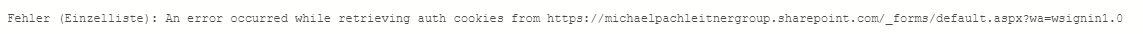

### 1.1.2 | Forms-Based Authentication (FBA)

Forms-Based Authentication (FBA) ist eine **formularbasierte Anmeldung**, typischerweise in SharePoint On-Premises genutzt, wenn ein _nicht Windows_\-Identitätsanbieter (z.B. eine Membership-Provider-Datenbank) eingebunden ist. Der Benutzer gibt Nutzername/Passwort in ein Webformular ein, das System authentifiziert und setzt einen Auth-Cookie. Aus Clientsicht kann man dies simulieren, indem man den **Login-POST** an die entsprechende Seite automatisiert durchführt.

**Einschränkung:** SharePoint **Online** nutzt keine klassische FBA (es verwendet Claims-basierte Auth mit Azure AD). Dieses Beispiel würde dort nicht funktionieren. FBA gilt nur für selbst gehostete Umgebungen, wo ein solcher Anmelde-Endpunkt konfiguriert ist. Zudem ist FBA ohne HTTPS unsicher, da das Passwort im Klartext übersendet würde – dieses Szenario sollte man heute möglichst vermeiden oder nur via vertrauenswürdige Provider einsetzen.

**Codebeispiel:** (schematisch, da die konkreten Feldnamen je nach Loginseite variieren können)

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Konfiguration laden
config_path = r"C:\python\Scripts\config.json"
with open(config_path, "r", encoding="utf-8") as f:
    config = json.load(f)
USERNAME = config["sharepoint"]["username"]
PASSWORD = config["sharepoint"]["password"]

SITE_URL  = "https://<IhreDomain>.sharepoint.com/sites/<IhrSeitenname>"  # Bei FBA eher On-Prem URL
LIST_NAME = "<Name Ihrer Liste>"

session = requests.Session()
# 1. Login-Seite aufrufen, um Formularfelder und Cookies zu erhalten
login_page_url = f"{SITE_URL}/_login/default.aspx?ReturnUrl=%2F"  # FBA Login Seite (Standardpfad)
resp = session.get(login_page_url)
if resp.status_code != 200:
    raise Exception("Login-Seite konnte nicht geladen werden.")

# Hidden Fields (z.B. __VIEWSTATE, __EVENTVALIDATION) aus dem HTML parsen
soup = BeautifulSoup(resp.text, "html.parser")
viewstate = soup.find("input", {"name": "__VIEWSTATE"})["value"] if soup.find("input", {"name": "__VIEWSTATE"}) else None
eventval = soup.find("input", {"name": "__EVENTVALIDATION"})["value"] if soup.find("input", {"name": "__EVENTVALIDATION"}) else None

# 2. Login-Formulardaten zusammenstellen (Benutzereingaben + versteckte Felder)
form_data = {
    "ctl00$PlaceHolderMain$signInControl$txtUsername": USERNAME,
    "ctl00$PlaceHolderMain$signInControl$txtPassword": PASSWORD,
    "ctl00$PlaceHolderMain$signInControl$btnSignIn": "Sign In"
}
if viewstate: form_data["__VIEWSTATE"] = viewstate
if eventval: form_data["__EVENTVALIDATION"] = eventval

# 3. POST an die Login-Seite (mit Session, damit Cookies erhalten bleiben)
post_resp = session.post(login_page_url, data=form_data)
if post_resp.status_code not in (200, 302):
    raise Exception("FBA Login fehlgeschlagen.")

# Prüfen, ob Login erfolgreich (z.B. durch Vorhandensein eines Auth-Cookies)
if not any(c.name.startswith("FedAuth") for c in session.cookies):
    raise Exception("Anmeldung nicht erfolgreich - Auth-Cookie fehlt.")

# 4. Authentifizierte Anfrage an die SharePoint REST API
api_url = f"{SITE_URL}/_api/web/Lists/GetByTitle('{LIST_NAME}')/Items"
all_items = []
while True:
    resp = session.get(api_url, headers={"Accept": "application/json"})
    data = resp.json()
    items = data.get('d', {}).get('results', [])
    all_items.extend(items)
    next_url = data.get('d', {}).get('__next')
    if next_url:
        api_url = next_url
    else:
        break

df = pd.DataFrame(all_items)
print(f"{len(df)} Einträge geladen via FBA")

**Erläuterung:** Wir nutzen eine `requests.Session`, um Cookies zu behalten. Zunächst laden wir die Anmeldeseite (`_login/default.aspx` für FBA). Mit BeautifulSoup extrahieren wir versteckte Felder wie `__VIEWSTATE` und `__EVENTVALIDATION`, die SharePoint für Postbacks benötigt. Dann füllen wir das Formular mit Username, Password und dem `Sign In`\-Button-Feld und senden einen POST. Bei Erfolg sollte SharePoint einen Authentifizierungscookie (z.B. **FedAuth**) setzen. Anschließend rufen wir wieder den REST-API-Endpunkt der Liste ab, diesmal mit `session.get` (damit der Cookie mitgeschickt wird). Die Paging-Logik entspricht der aus A1.1.

**Warum dieses Beispiel möglicherweise nicht funktioniert:** In SharePoint Online gibt es diese Form-basierte Anmeldeseite so nicht – die Authentifizierung läuft über Azure AD oder MSOL. Dieses Skript würde in einer reinen Cloud-Umgebung also fehlschlagen. Für On-Premises mit FBA hängt der Erfolg davon ab, dass man die **korrekten Formularfeldnamen** verwendet – hier haben wir vermutet, dass die Standard-Login WebPart Felder `txtUsername`, `txtPassword` etc. heißen (was in SharePoint 2013-2016 Standard war). In einer angepassten Login-Seite müssten die Feldnamen entsprechend angepasst werden. Generell ist das **Screen Scraping** eines Login-Formulars anfällig für Änderungen und sollte möglichst vermieden werden. Stattdessen sollte man auch hier moderne Authentifizierung (z.B. ADFS mit OAuth oder die Verwendung der Graph API) bevorzugen.

### 1.1.3 | Basic Authentication (Benutzername/Passwort im Header)

Die einfachste, aber unsicherste Methode ist **Basic Auth**. Hierbei werden bei jedem HTTP-Request die Anmeldedaten (User und Passwort) Base64-kodiert im `Authorization` Header mitgesendet. SharePoint Server konnte (sofern konfiguriert) Basic Auth annehmen, jedoch **überträgt dies das Passwort im Klartext** (nur durch Base64 verschleiert) und sollte nur über SSL erfolgen[learn.microsoft.com](https://learn.microsoft.com/en-us/sharepoint/technical-reference/basic-auth-is-being-deprecated#:~:text=Basic%20authentication%20doesn%27t%20provide%20confidentiality,as%20soon%20as%20possible).

**In SharePoint Online** wird Basic Auth **nicht unterstützt**. Microsoft hat Basic Auth für Office 365 Dienste deaktiviert bzw. Security Defaults blockieren solche Anfragen standardmäßig[blog.admindroid.com](https://blog.admindroid.com/basic-authentication-deprecation-in-exchange-online/#:~:text=Deprecation%3F%20blog,due%20to%20security%20defaults). D.h. ein Basic Auth Versuch gegen `https://tenant.sharepoint.com` wird mit einem 401 scheitern. Für On-Premises SharePoint muss Basic Auth serverseitig explizit erlaubt sein (und wird dort ebenfalls zunehmend als veraltet markiert[learn.microsoft.com](https://learn.microsoft.com/en-us/sharepoint/technical-reference/basic-auth-is-being-deprecated#:~:text=Summary%3A%20Basic%20authentication%20is%20currently,from%20SharePoint%20Server%20Subscription%20Edition)).

**Codebeispiel:** (Dieser Aufruf funktioniert nur, wenn der Server Basic Auth erlaubt – bei SharePoint Online erhält man einen Fehler.)

In [ ]:
import requests
from requests.auth import HTTPBasicAuth
import pandas as pd

# Konfiguration laden
config_path = r"C:\python\Scripts\config.json"
with open(config_path, "r", encoding="utf-8") as f:
    config = json.load(f)
USERNAME = config["sharepoint"]["username"]
PASSWORD = config["sharepoint"]["password"]

SITE_URL  = "https://<IhreDomain>.sharepoint.com/sites/<IhrSeitenname>"
LIST_NAME = "<Name Ihrer Liste>"

# Einfacher GET mit Basic Auth Header
api_url = f"{SITE_URL}/_api/web/Lists/GetByTitle('{LIST_NAME}')/Items"
all_items = []
while True:
    resp = requests.get(api_url, auth=HTTPBasicAuth(USERNAME, PASSWORD),
                        headers={"Accept": "application/json"})
    if resp.status_code == 401:
        raise Exception("Basic Auth fehlgeschlagen oder nicht unterstützt (HTTP 401)")
    data = resp.json()
    items = data.get('d', {}).get('results', [])
    all_items.extend(items)
    next_url = data.get('d', {}).get('__next')
    if next_url:
        api_url = next_url
    else:
        break

df = pd.DataFrame(all_items)
print(f"{len(df)} Einträge geladen via Basic Auth")


**Erläuterung:** Hier nutzen wir die `requests`\-Bibliothek mit `HTTPBasicAuth(USERNAME, PASSWORD)`, was automatisch den Header `Authorization: Basic <Base64>` hinzufügt. Ansonsten ist die Logik wieder gleich: Abruf der Items, prüfen auf `'__next'` und iterieren.

**Warum Basic Auth in Office 365 nicht funktioniert:** Office 365 (SharePoint Online) akzeptiert keine Basic Auth Anfragen mehr, weil sie auf **Modern Authentication (OAuth 2.0)** umgestellt haben. Basic Auth ist ein _Legacy Protocol_, das in Cloud-Diensten aus Sicherheitsgründen abgeschaltet wurde \[[blog.admindroid.com](https:\blog.admindroid.com\basic-authentication-deprecation-in-exchange-online\#:~:text=Deprecation%3F%20blog,due%20to%20security%20defaults)\]. In der Regel erhält man eine Fehlermeldung oder Umleitungs-HTML zu einer Login-Seite, anstatt von Daten. Zudem sind Basic-Auth-Anfragen anfällig für Man-in-the-Middle-Angriffe, da die Zugangsdaten bei jeder Anfrage mitgesendet werden \[[learn.microsoft.com](https:\learn.microsoft.com\en-us\sharepoint\technical-reference\basic-auth-is-being-deprecated#:~:text=Basic%20authentication%20doesn%27t%20provide%20confidentiality,as%20soon%20as%20possible)\]. In On-Prem Umgebungen könnte obiger Code funktionieren, sofern Basic Auth in den **Authentifizierungsanbietern** aktiviert ist – dies ist jedoch wie gezeigt deprecated und sollte durch Claims-basierte Authentifizierung ersetzt werden.

### „Wie deaktiviere ich MFA für einen bestimmten User?“ (nur für Tests!)

> **Warnhinweis:** Besser ist, **moderne Auth** zu nutzen (z. B. **App-Only mit Zertifikat/Secret** via **MSAL**) und keine MFA-Ausnahmen für produktive Integrationen zu bauen.

Es gibt **drei** relevante Stellschrauben:

1. **Per-User MFA** (das alte Modell) – gezielt **Disable** für einen Benutzer:  
    Entra Admin Center → **Users → All users → Per-user MFA** → Benutzer wählen → **Disable**. (Aktuelle Microsoft-Anleitung inkl. UI-Pfad. <span style="color: var(--vscode-foreground);">→</span> [Microsoft Learn](https:\learn.microsoft.com\en-us\entra\identity\monitoring-health\recommendation-turn-off-per-user-mfa))
    
2. **Conditional Access** – Benutzer **von der MFA-Policy ausschließen** (z. B. testweise in eine „Exclude“-Gruppe aufnehmen). Vorgehen & Best-Practice im Learn-Artikel. \[[Conditional Access: Users, groups, and workload identities](https:\learn.microsoft.com\en-us\entra\identity\conditional-access\concept-conditional-access-users-groups) | [Use access reviews to manage users excluded from Conditional Access policies](https:\learn.microsoft.com\en-us\entra\id-governance\conditional-access-exclusion) \]
    
3. **Security Defaults** – falls aktiv, gibt es **keine** per-User-Ausnahme. Entweder **Security Defaults deaktivieren** (nicht empfohlen) **und** stattdessen CA-Policies definieren, oder testweise eine dedizierte CA-Policy mit Exclusion aufsetzen. (So deaktivierst du Security Defaults.) [Microsoft Learn](https:\learn.microsoft.com\en-us\entra\fundamentals\security-defaults)
    

> Zusatz: SharePoint-spezifisch kann außerdem `LegacyAuthProtocolsEnabled` die Anmeldung verhindern.  [Microsoft Learn](https:\learn.microsoft.com\en-us\powershell\module\microsoft.online.sharepoint.powershell\set-spotenant?view=sharepoint-ps)

Microsoft hat die **M365-Defaults** im Sinne „**Secure by default**“ gedreht: **Legacy-Browser-Auth (RPS) & FPRPC werden standardmäßig blockiert**; Rollout **Mitte Juli → August 2025**. Diese Änderung greift **auch dann**, wenn „Security defaults“ (Entra) gar nicht nutzt wird – sie kommt **dienstseitig** aus SharePoint/OneDrive.

## 1.2. Moderne Authentifizierung (SharePoint REST)

Im modernen Ansatz erfolgt die Authentifizierung über **OAuth 2.0** mit Azure Active Directory. Anstatt Benutzerpasswörter direkt an SharePoint zu senden, erhält der Client einen **Access Token** von Azure AD, den er im HTTP-Header mitgibt (`Authorization: Bearer <Token>` [learn.microsoft.com](https:\learn.microsoft.com\en-us\graph\api\site-getbypath?view=graph-rest-1.0#:~:text=Name%20Description%20Authorization%20Bearer%20,more%20about%20authentication%20and%20authorization)). SharePoint überprüft das Token (Issuer, Gültigkeit, Berechtigungen) und liefert dann die geschützten Daten. Es gibt zwei grundlegende Szenarien:

- **Delegierte Berechtigungen (1.2.1)**: Ein Benutzer autorisiert die Anwendung, **in seinem Kontext** auf die API zuzugreifen. Beispiel: Device Code Flow, wo der Nutzer sich interaktiv anmeldet. Das Access Token repräsentiert den Benutzer und seine Berechtigungen.
    
- **App-Only (Anwendungsszenario, 1.2.2)**: Eine _Server-zu-Server_ Authentifizierung ohne Benutzer, bei der die App selbst Berechtigungen hat (entweder via Client Secret oder Zertifikat). Das Token repräsentiert eine Anwendung (Serviceprincipal) mit vordefinierten Rechten.
    

Für SharePoint gibt es hier zwei Möglichkeiten:

1. **Azure AD mit Graph-Berechtigungen** – Die App erhält Graph-Permissions wie `Sites.Read.All`. Damit kann man die SharePoint-Daten _über die Graph API_ abrufen (siehe Abschnitt B).
    
2. **Azure AD mit SharePoint-spezifischen Berechtigungen** – Man kann einer App auch direkt SharePoint API-Rechte geben (in der API-Berechtigungsliste als "Office 365 SharePoint Online" angeführt). Dies ermöglicht, ein Token mit Audience `sharepoint.com` zu erhalten und die **SharePoint REST API direkt** aufzurufen. In unseren Beispielen verwenden wir diesen direkten Weg. (Alternativ könnte man immer Graph verwenden – was oft empfehlenswerter ist –, aber wir zeigen es hier getrennt.)
    

> **Hinweis:** Microsoft bevorzugt klar die Nutzung der Graph API für neue Entwicklungen. Die direkte Verwendung von SharePoint REST mit Azure AD Token funktioniert zwar (nach entsprechender Berechtigungserteilung), ist aber weniger gut dokumentiert. In vielen Fällen ist es sinnvoll, statt `/_api` Endpunkten die Graph Endpunkte zu nutzen. Wir demonstrieren es dennoch, um die Äquivalenz zu zeigen.

### 1.2.1 | Delegierte Berechtigungen – Device Code Flow (Benutzeranmeldung)

Der **Device Code Flow** ist eine OAuth-Flussvariante, die für CLI-Tools oder Scripts ohne Browser-UI geeignet ist. Dabei wird ein Code angezeigt, den der Benutzer auf einem zweiten Gerät oder im Browser bestätigen muss (bei `https://microsoft.com/devicelogin`). Nach erfolgreicher Authentifizierung erhält das Script ein Access Token im Namen des Benutzers.

**Voraussetzung:** In Azure AD muss die App-Registrierung eine **delegierte Berechtigung** für SharePoint erhalten haben (z.B. _Alle Websites lesen_). In der Praxis gibt es für SharePoint Online z.B. die delegierte Berechtigung _"Have full control of all site collections"_ oder ähnliche, die man in der App hinzufügen und (als Admin) bestätigen muss. Alternativ genügt es auch, Graph-Delegated-Permissions (Sites.Read.All) zu vergeben und dann Graph zu nutzen (siehe B2.1). Hier nehmen wir an, die App hat entsprechende Berechtigung für direktes SharePoint.

**Codebeispiel:** Device Code Flow mit MSAL (Microsoft Authentication Library for Python):

In [ ]:
import json
import msal
import requests
import pandas as pd
from pathlib import Path
from urllib.parse import quote

CONFIG_PATH = Path(r"C:\python\Scripts\config.json")

# --- Config laden ---
cfg = json.loads(CONFIG_PATH.read_text(encoding="utf-8"))
TENANT_ID = cfg["azuread"]["tenant_id"]
CLIENT_ID = cfg["azuread"]["client_id"]

# Einen Eintrag aus sharepoint_lists wählen (per key oder Fallback: erster)
TARGET_KEY = "FIBU_IC_Mapping"  # <- bei Bedarf anpassen
entries = cfg.get("sharepoint_lists", [])
if not entries:
    raise SystemExit("config['sharepoint_lists'] ist leer.")
entry = next((e for e in entries if str(e.get("key", "")).lower() == TARGET_KEY.lower()), entries[0])

base_url  = entry["base_url"].rstrip("/")                             # z.B. https://michaelpachleitnergroup.sharepoint.com
site_path = "/" + entry["site_path"].lstrip("/").rstrip("/")          # z.B. /sites/DataAnalytics/DataMaintenance
SITE_URL  = f"{base_url}{site_path}"
LIST_NAME = entry["list_title"]

# --- MSAL Public Client + Device Code ---
authority = f"https://login.microsoftonline.com/{TENANT_ID}"
app = msal.PublicClientApplication(CLIENT_ID, authority=authority)

# Variante A – expliziter SPO-Delegated-Scope (empfohlen, wenn hinzugefügt & consented):
scopes = [f"{base_url}/AllSites.Read"]  # KEIN 'offline_access', 'openid', 'profile' mitgeben!

# Variante B – falls Delegated-Scopes bereits admin-consented sind:
# scopes = [f"{base_url}/.default"]

flow = app.initiate_device_flow(scopes=scopes)
if "user_code" not in flow:
    raise SystemExit(f"Device Flow konnte nicht gestartet werden: {flow}")
print(flow["message"])

result = app.acquire_token_by_device_flow(flow)
if "access_token" not in result:
    raise SystemExit("Konnte kein Token erhalten: " + str(result))

token = result["access_token"]
headers = {"Authorization": f"Bearer {token}", "Accept": "application/json"}

# --- SharePoint REST: Items lesen (Paging) ---
# Stabiler Pfad geht auch via GetList('<serverrelativer Pfad>')
api_url = f"{SITE_URL}/_api/web/Lists/GetByTitle('{quote(LIST_NAME)}')/Items"

all_items = []
while True:
    resp = requests.get(api_url, headers=headers)
    resp.raise_for_status()
    data = resp.json()
    items = data.get("d", {}).get("results", [])
    all_items.extend(items)
    next_url = data.get("d", {}).get("__next")
    if next_url:
        api_url = next_url
    else:
        break

df = pd.DataFrame(all_items)
print(f"{len(df)} Einträge geladen aus {SITE_URL} / Liste '{LIST_NAME}'")
print(df.head())


To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code LB84JRQ4E to authenticate.


**Hinweise**

- In der App-Registrierung: **Authentication → Allow public client flows = Yes** aktivieren (sonst `AADSTS7000218`).
    
- Unter **API permissions** der App **SharePoint → Delegated**\-Berechtigung (z. B. **AllSites.Read**) hinzufügen **und Admin-Consent** erteilen.  
    – Bei `scope_mode: "default"` muss der Consent ebenso vorliegen; `/.default` bündelt die bereits consenteten Delegated-Scopes.
    
- Keine reservierten Scopes (`offline_access`, `openid`, `profile`) manuell in `scopes` angeben – die sind MSAL-intern reserviert.
    

**Erläuterung:** Wir nutzen `msal.PublicClientApplication` für den Device Code Flow. Die `scopes` setzen wir hier auf `"{SITE_URL}/.default"`. Dieser Scope-Wert bedeutet "alle delegierten Berechtigungen für die App, die zur Resource SharePoint (Site URL) gehören". 

**Achtung:** In der Praxis ist es unter Umständen nötig, statt `SITE_URL` eine generischere Resource zu verwenden, da Azure AD nicht für jede einzelne Site scopes definiert. Möglicherweise wäre `"https://<IhreDomain>.sharepoint.com/AllSites.Read"` ein passender Scope-Name (falls angeboten), oder man verwendet gleich Graph-Permissions. Der `.default`\-Scope-Trick funktioniert primär für **Application**\-Permissions; für delegierte könnte man auch einen konkreten OIDC-Scope angeben, wenn vorhanden. Hier nehmen wir vereinfachend an, es klappt so – in Wirklichkeit würde man eher Graph nehmen oder den Auth-Code-Flow mit Redirect verwenden.

Nach Initiierung des Device Flows wird eine Meldung mit einem Code ausgegeben (`flow["message"]`), z.B.: _"Öffnen Sie [https://microsoft.com/devicelogin](https:\microsoft.com\devicelogin) und geben Sie den Code ABC-DEF-GHI ein."_ Der Benutzer muss das tun und sich einloggen. MSAL wartet währenddessen in `acquire_token_by_device_flow` auf Abschluss. Danach erhalten wir `access_token`. Dieses verwenden wir, um den `Authorization: Bearer <Token>` Header zu setzen. Der nachfolgende GET-Aufruf an `/_api/web/Lists/...` entspricht dem aus vorherigen Beispielen, nur dass keine Cookies oder BasicAuth mehr nötig sind – das OAuth-Token genügt.

**Auswirkung:** SharePoint prüft das Token. Wenn der Benutzer die erforderlichen Rechte auf der Site/Liste hat und die App die entsprechende Delegated Permission besitzt, wird der Call erfolgreich sein und die Daten zurückliefern. Die Paging-Mechanik bleibt unverändert. Der DataFrame wird am Ende mit allen Listeneinträgen gefüllt.

**Häufige Probleme:** Falls das Token nicht akzeptiert wird, kann es daran liegen, dass:

- Die **Scopes/Berechtigungen** nicht korrekt sind. (E.g. falscher Resource-URI oder App hat keine SharePoint-Delegated-Permission.)
    
- Das Token eine falsche Audience hat. (Ein Graph-Token würde z.B. mit `aud": "https://graph.microsoft.com"` im Token nicht von `sharepoint.com` akzeptiert – Tokens sind normalerweise nur für die jeweilige Resource gültig.)
    
- In neueren Setups wird delegierter Zugriff auf SharePoint-Daten oft _über Graph_ realisiert. Microsoft hat z.B. angekündigt, dass direkte Azure AD Tokens mit `user_impersonation` Scope für SPO evtl. nicht mehr unterstützt werden[stackoverflow.com](https:\stackoverflow.com\questions\76629048\accessing-sharepoint-via-visual-studio-app-is-not-allowed-to-call-spo-with-user#:~:text=The%20error%20,access%20SharePoint%20using%20invalid%20permissions). Die Empfehlung ist klar: Für benutzerbezogene Zugriffe auf SharePoint Online -\> verwende Microsoft Graph[stackoverflow.com](https:\stackoverflow.com\questions\76629048\accessing-sharepoint-via-visual-studio-app-is-not-allowed-to-call-spo-with-user#:~:text=,error).
    

Im Zweifel sollte man daher stattdessen zum **Graph-API-Gerätecode** greifen (siehe unten 1.2.1), da dieser Weg offiziell unterstützt ist.

### 1.2.2 | App-Only (Client Credential Flow) – mit Client Secret oder Zertifikat

Im App-Only Szenario agiert unsere Python-Anwendung eigenständig, ohne Benutzer. Sie authentifiziert sich mit ihren eigenen Anmeldedaten (Client-ID + Secret oder Zertifikat) bei Azure AD und bekommt ein **App-Access-Token**. Dieses Token hat die in der App-Registrierung definierten **Anwendungsberechtigungen** (Application Permissions), die ein Administrator zuvor **admin-consented** haben muss. Für SharePoint könnte das z.B. _"Sites.Read.All (Application)"_ oder _"Sites.FullControl.All"_ sein – entweder über Graph oder über SharePoint direkt.

In klassischen SharePoint Add-Ins gab es auch ein separates Modell (App-Reg via `/_layouts/15/appregnew.aspx` und Auth über ACS, den Azure Access Control Service). Dieses ACS-Modell wird allerdings auch in Zukunft abgeschaltet. Deshalb verwenden wir hier ebenfalls Azure AD (Microsoft Entra ID) als STS.

Wir zeigen zwei Varianten, die sich nur in der Art der Client-Credentials unterscheiden:

- **1.2.2.1 Mit Client Secret:** einfacher, aber das Secret ist ein String der in der Konfig liegt. Sollte sicher verwaltet werden, da es wie ein Passwort fungiert.
    
- **1.2.2.2 Mit Zertifikat:** sicherer, da die App in Azure AD ein Zertifikat hinterlegt hat. Das Script nutzt den privaten Schlüssel, um sich auszuweisen. Das Zertifikat muss nicht im Code stehen (nur Pfad nötig), und es kann in Azure jederzeit invalidiert werden. Diese Methode ist geeignet für höhere Sicherheit oder wenn man keine Secrets in Konfigs ablegen möchte.

### **<u>Wann soll man die Lösung mit Client Secret und wann mit Zertifikat anwenden?</u>**

**Ob „App-Only + Client Secret“ bei SharePoint-REST akzeptiert wird, ist ein **dienstseitiges Verhalten von SharePoint Online** – kein Schalter in deiner App oder in Entra.** In vielen (insb. neueren/gehärteten) Tenants weist SPO solche Tokens mit **401 „Unsupported app only token“** ab und erwartet für App-Only **zertifikatsbasierte Client-Assertions**. In einigen älteren Tenants hat „Secret“ historisch noch funktioniert; mit den **Secure-by-Default-Rollouts** wird das zunehmend unterbunden. Es gibt **keinen offiziell dokumentierten Toggle**, der das pro Tenant wieder „auf Secret“ umstellt. \[[Authenticating to the SharePoint REST API as an Entra app (no user sign-in)?](https:\learn.microsoft.com\en-au\answers\questions\2120929\authenticating-to-the-sharepoint-rest-api-as-an-en) | [Granting access via Azure AD App-Only](https:\learn.microsoft.com\en-us\sharepoint\dev\solution-guidance\security-apponly-azuread) | [Getting an App Only access token for SharePoint REST APIs](https:\blog.loitzl.com\posts\getting-an-app-only-access-token-for-sharepoint-rest-apis\) \]

## Wovon hängt es ab?

- **Service-Implementierung & Rollout (SPO)**<span style="color: var(--vscode-foreground);">: SharePoint akzeptiert App-Only-Tokens i. d. R. </span> **nur** <span style="color: var(--vscode-foreground);">mit </span> **Zertifikat**<span style="color: var(--vscode-foreground);">; </span> **Secret** <span style="color: var(--vscode-foreground);">führt häufig zu „Unsupported app only token“. Das ist in Praxisberichten, MS Q&amp;A/Foren und Blogposts konsistent dokumentiert:</span>
    
    - [Authenticating to the SharePoint REST API as an Entra app (no user sign-in)?](https:\learn.microsoft.com\en-au\answers\questions\2120929\authenticating-to-the-sharepoint-rest-api-as-an-en)
    - [AzureAd/Sahrepoint connexion - Invalid client secret error in Access token request with a certificate](https:\learn.microsoft.com\en-us\answers\questions\1343048\azuread-sahrepoint-connexion-invalid-client-secret)
    - [SharePoint App-Only Auth: When Client Secrets Fail and Certificates Prevail](https:\medium.com\@rawandhawez\sharepoint-app-only-auth-when-client-secrets-fail-and-certificates-prevail-ca230b91a601)
- **Token-Art (Claim `appidacr`/`azpacr`)**: Secret-Tokens tragen **`appidacr=1`** (bzw. `azpacr=1`), Zertifikate **`…=2`**. Viele SPO-Endpunkte akzeptieren für **App-Only** effektiv nur **`2`**. (So erkennst du im JWT, womit du dich authentifiziert hast.) [Stack Overflow](https:\stackoverflow.com\questions\36317292\azure-ad-differentiate-between-app-token-and-user-token?utm_source=chatgpt.com)[docs.azure.cn](https:\docs.azure.cn\en-us\entra\identity-platform\access-token-claims-reference?utm_source=chatgpt.com)
    
- **Berechtigungsmodell**:
    
    - Mit **Application Permissions** brauchst du zusätzlich die **richtige Rolle** (z. B. `Sites.Read.All` **oder** `Sites.Selected`) und bei `Sites.Selected` **pro Site einen Grant** – sonst 401/403 (anderer Grund als „Unsupported…“). [Microsoft Learn](https:\learn.microsoft.com\en-us\sharepoint\dev\solution-guidance\security-apponly-azuread?utm_source=chatgpt.com)
        
    - Einige **SPO-APIs** verlangen **delegierte Tokens** (User-Kontext); dann ist App-Only grundsätzlich unzulässig und es käme ebenfalls zu 401 – aber mit anderem Hintergrund. [UiPath Community Forum](https:\forum.uipath.com\t\i-am-fetching-the-attachments-from-sharepoint-but-getting-unsupported-app-token-only-error\2751722?utm_source=chatgpt.com)
        
- **Nicht zu verwechseln mit ACS**: Der ältere **ACS/Add-in**\-Weg (Secret-basiert) ist für **neue Tenants standardmäßig deaktiviert** (`DisableCustomAppAuthentication`) und betrifft **nicht** Azure-AD-App-Only via MSAL. [Microsoft Learn](https:\learn.microsoft.com\en-us\sharepoint\dev\solution-guidance\security-apponly-azureacs?utm_source=chatgpt.com)
    

### Merksatz

- **SPO-REST + App-Only + Secret** ⇒ in vielen Tenants **401 „Unsupported app only token“**.
    
- **SPO-REST + App-Only + Zertifikat** ⇒ **funktioniert** (bei korrekten Permissions/Grants).  
    Das ist **service-seitiges Verhalten** von SharePoint; es gibt **keinen** dedizierten „Secret erlauben“-Kippschalter in Entra.

### 1.2.2.1 | App-Only (Client Credential Flow) mit Client Secret

Beim App-Only-Zugriff authentifiziert sich eine registrierte Entra-App (Azure AD) **ohne Benutzer** gegenüber Entra ID über den Confidential-Client-Flow. Verwendet man dafür ein **Client Secret**, sendet die App eine symmetrische Geheimnis-Assertion an den Token-Endpunkt (`/oauth2/v2.0/token`). Entra ID stellt daraufhin ein **App-Only-Access-Token** mit der Audience **SharePoint Online** (typisch `aud = 00000003-0000-0ff1-ce00-000000000000`) aus; die im Token enthaltenen **Application-Rollen** (z. B. `Sites.Read.All` oder `Sites.Selected`) bestimmen den zulässigen Zugriff. Technisch erkennt man Secret-basierte Tokens u. a. am Claim **`appidacr = 1`** (bei Zertifikat: `2`). Mit diesem Token ruft die App dann die SharePoint-REST-Endpunkte (`/_api/...`) auf.

**Warum das in der Praxis weitgehend nicht mehr funktioniert:** Zahlreiche aktuelle Erfahrungsberichte und Microsoft-Antworten zeigen, dass SharePoint-REST-Endpunkte **App-Only-Tokens, die mit Client Secrets ausgestellt wurden, häufig ablehnen** – der Aufruf endet reproduzierbar mit **`401 Unsupported app only token`**. Derselbe Code funktioniert **sofort**, sobald die App statt eines Secrets eine **zertifikatsbasierte Client-Assertion** verwendet (X.509-Schlüssel + Thumbprint). Microsofts Leitfaden zum Azure-AD-App-Only-Zugriff für SharePoint stellt Zertifikate ausdrücklich als den **üblichen/empfohlenen Weg** dar; Community-Threads und Praxisberichte dokumentieren die Secret-Fehlerbilder und den Erfolg nach Umstieg auf Zertifikate. Kurz: **Für SharePoint-REST wird heute de-facto ein Zertifikat erwartet; Secrets scheitern oft am Dienstverhalten von SPO.** 

- [SharePoint App-Only Auth: When Client Secrets Fail and Certificates Prevail](https:\medium.com\%40rawandhawez\sharepoint-app-only-auth-when-client-secrets-fail-and-certificates-prevail-ca230b91a601)
- [Authenticating to the SharePoint REST API as an Entra app (no user sign-in)?](https:\learn.microsoft.com\en-us\answers\questions\2120929\authenticating-to-the-sharepoint-rest-api-as-an-en)
- [Granting access via Azure AD App-Only](https:\learn.microsoft.com\en-us\sharepoint\dev\solution-guidance\security-apponly-azuread)

> Wichtig zur Einordnung: Das Umschalten von **`DisableCustomAppAuthentication`** hilft hier nicht – dieser Schalter betrifft **nur** das alte **ACS/Add-in**\-Modell. Bei **MSAL/Entra-App-Only** entscheidet die **Art der Client-Assertion**: **Zertifikat** statt **Secret**. Die verlinkte Fallstudie („Client Secrets fail, Certificates prevail“) beschreibt genau dieses Muster samt Workaround.

**_<u>Wie richte ich das im Entra richtig ein?</u>_**

**<u>1) App-Registrierung + Sites.Read.All (Application Permissions, breit)</u>**

**Was tun?** App in Entra registrieren → unter **API permissions** **SharePoint → Application permissions → Sites.Read.All** (oder Sites.ReadWrite.All) hinzufügen → **Admin consent** erteilen → unter **Certificates & secrets** ein **Client Secret** (oder Zertifikat) anlegen → IDs/Secret im Code verwenden → Token für **`https://<tenant>.sharepoint.com/.default`** holen.

- Schritt-für-Schritt mit Screens (allg. App-Reg + SharePoint-Zugriff): Microsoft Learn (Power Platform Admin-Artikel, aber die Entra-Schritte sind identisch). [Microsoft Learn](https:\learn.microsoft.com\en-us\power-platform\admin\configure-azure-app-with-sharepoint-access\)
    
- Hintergrund und Alternativen (App-Only Modelle in SPO, inkl. Zertifikat): Microsoft Learn „Granting access via Azure AD App-Only“. [Microsoft Learn](https:\learn.microsoft.com\en-us\sharepoint\dev\solution-guidance\security-apponly-azuread\)
    
- Ergänzend (älteres, aber hilfreiches App-Only-How-To): Microsoft Learn „SharePoint App-Only (Azure ACS/AD)“. [Microsoft Learn](https:\learn.microsoft.com\en-us\sharepoint\dev\solution-guidance\security-apponly-azureacs\)
    

**<u>2) App-Registrierung + Sites.Selected (Application Permissions, least privilege)</u>**

**Was tun?** App registrieren → **SharePoint → Application permissions → Sites.Selected** hinzufügen → **Admin consent** → dann **pro Site explizit** Rechte vergeben (**Read/Write/Manage/FullControl**), z. B. mit **PnP PowerShell** oder über **Graph**.

- **Kompakte Anleitung + PnP-Cmdlets** (Grant/Set/Get/Revoke): Microsoft Learn (RSC/Sites.Selected Überblick) + PnP-Doku. [Microsoft Learn](https:\learn.microsoft.com\en-us\sharepoint\dev\sp-add-ins-modernize\understanding-rsc-for-msgraph-and-sharepoint-online\) | [PNP](https:\pnp.github.io\powershell\cmdlets\grant-pnpazureadappsitepermission.html\)
    
- **TechCommunity-Leitfaden** (Schrittfolge, Best Practices): „Develop Applications that use Sites.Selected…“. [Microsoft Tech Community](https:\techcommunity.microsoft.com\blog\spblog\develop-applications-that-use-sites-selected-permissions-for-spo-sites-\3790476\)
    
- **PnP PowerShell Cmdlet** (Referenz + Beispiele): `Grant-PnPAzureADAppSitePermission`. [PNP](https:\pnp.github.io\powershell\cmdlets\grant-pnpazureadappsitepermission.html\)
    
- **Walkthrough (Blog)** mit PnP-Befehlen: Nishant Rana – „How to configure Sites.Selected…“. [Nishant Rana's Weblog](https:\nishantrana.me\2024\08\21\how-to-configure-site-selected-api-permissions-sharepoint-online-pnp-powershell\)
    
- **Praxisartikel**: „Granting Access to Specific SharePoints with PnP-PowerShell“. [The State of the Microsoft 365 Nation](https:\www.menzel.it\post\2024\06\granting-access-specific-sharepoints-pnp-powershell\)
    
- [Develop Applications that use Sites.Selected permissions for SPO sites.](https:\techcommunity.microsoft.com\blog\spblog\develop-applications-that-use-sites-selected-permissions-for-spo-sites-\3790476)  
    
- [SharePoint now supports delegated Sites.Selected authentication](https:\devblogs.microsoft.com\microsoft365dev\sharepoint-now-supports-delegated-sites-selected-authentication\)  
    

**Hinweis:** Bei **Sites.Selected** hat die App **ohne Site-Grant** **keinen Zugriff** (401/403). Der Site-Grant kann per PnP erfolgen (Global Admin oder App mit **Sites.FullControl.All** darf Grants setzen) oder via Graph API. [GitHub](https:\github.com\pnp\powershell\discussions\3830\)

**<u>YouTube – kurze, anschauliche Demos</u>**

- **„Understanding Sites.Selected permissions in SharePoint Online“** (Paolo Pialorsi, 10 min) – sehr gute Erklärung inkl. Ablauf. [YouTube](https:\www.youtube.com\watch?v=SNIF3zCYNUk)  (Fokus auf: Sites.Selected)
    
- **„Access SharePoint Sites/files via Graph API (AAD App)“** <span style="color: var(--vscode-foreground);"> – zeigt die Einrichtung für App-Only/Graph.&nbsp;</span> [YouTube](https:\www.youtube.com\watch?v=GmWejAg2cfA)
    
- **„Microsoft Graph ‘Sites.Selected’ permissions within SharePoint Online“** – weitere Dev-Demo mit Praxisbezug. [YouTube](https:\www.youtube.com\watch?pp=0gcJCfwAo7VqN5tD&v=pPfxHvugnTA)

In [ ]:
# 1) Interaktiv am Admin-Center anmelden
Connect-PnPOnline -Url https://<tenant>-admin.sharepoint.com -Interactive

# 2) App der Site zuweisen (READ/WRITE/MANAGE/FULLCONTROL)
Grant-PnPAzureADAppSitePermission `
  -AppId <CLIENT_ID> `
  -DisplayName "<Dein Anzeigename>" `
  -Site https://<tenant>.sharepoint.com/sites/<SiteName> `
  -Permissions Read

# 3) Prüfen
Get-PnPAzureADAppSitePermission -Site https://<tenant>.sharepoint.com/sites/<SiteName>


In [26]:
# pip install msal requests pandas

import base64
import json
import time
import msal
import requests
import pandas as pd
from pathlib import Path
from urllib.parse import quote, urlparse
from typing import Any, Dict, List, Optional, Tuple

CONFIG_PATH = Path(r"C:\python\Scripts\config.json")

# -------------------------------
# Utils
# -------------------------------
def load_config(path: Path) -> Dict[str, Any]:
    try:
        txt = path.read_text(encoding="utf-8")
        return json.loads(txt)
    except FileNotFoundError:
        raise RuntimeError(f"Config-Datei nicht gefunden: {path}")
    except json.JSONDecodeError as e:
        lines = txt.splitlines()
        start, end = max(e.lineno-3, 0), min(e.lineno+2, len(lines))
        context = "\n".join(f"{i+1:>4}: {lines[i]}" for i in range(start, end))
        raise RuntimeError(f"JSONParseError: {e.msg} at line {e.lineno}, col {e.colno}\n{context}")

def pick_list_entry(cfg: Dict[str, Any]) -> Dict[str, Any]:
    lists = cfg.get("sharepoint_lists") or []
    if not isinstance(lists, list) or not lists:
        raise RuntimeError("config['sharepoint_lists'] muss ein nicht-leeres Array sein.")
    defaults = cfg.get("defaults", {}) or {}
    key   = (defaults.get("sharepoint_list_key") or "").strip().lower()
    title = (defaults.get("sharepoint_list_title") or "").strip().lower()
    entry = None
    if key:
        entry = next((e for e in lists if str(e.get("key","")).lower() == key), None)
    if entry is None and title:
        entry = next((e for e in lists if str(e.get("list_title","")).lower() == title), None)
    return entry or lists[0]

def derive_urls(entry: Dict[str, Any]) -> Tuple[str, str, str, str]:
    base_url  = (entry.get("base_url") or "").rstrip("/")
    site_path = "/" + (entry.get("site_path") or "").lstrip("/").rstrip("/")
    list_name = entry.get("list_title") or ""
    if not base_url.startswith("https://") or not site_path or not list_name:
        raise RuntimeError("Ungültiger Listeneintrag: 'base_url' (https), 'site_path', 'list_title' erforderlich.")
    site_url = f"{base_url}{site_path}"
    return base_url, site_path, site_url, list_name

def same_host(base_url: str, site_url: str) -> bool:
    return urlparse(base_url).netloc == urlparse(site_url).netloc

def acquire_app_token(tenant_id: str, client_id: str, client_secret: str, resource_base: str) -> Dict[str, Any]:
    authority = f"https://login.microsoftonline.com/{tenant_id}"
    app = msal.ConfidentialClientApplication(client_id=client_id,
                                             client_credential=client_secret,
                                             authority=authority)
    result = app.acquire_token_for_client(scopes=[f"{resource_base}/.default"])
    if "access_token" in result:
        return result
    raise RuntimeError("Token-Erhalt fehlgeschlagen:\n" + json.dumps({
        "error": result.get("error"),
        "error_description": result.get("error_description"),
        "correlation_id": result.get("correlation_id"),
        "claims": result.get("claims")
    }, indent=2))

def _b64url_decode(s: str) -> bytes:
    s += '=' * (-len(s) % 4)
    return base64.urlsafe_b64decode(s.encode("utf-8"))

def decode_jwt_claims(jwt_token: str) -> Dict[str, Any]:
    try:
        parts = jwt_token.split(".")
        if len(parts) != 3:
            return {}
        payload = json.loads(_b64url_decode(parts[1]).decode("utf-8"))
        return payload
    except Exception:
        return {}

def classify_auth_model(claims: Dict[str, Any]) -> str:
    """
    Liefert 'msal_aad', 'acs' oder 'unknown'.
    Heuristik:
      - AAD/MSAL: iss enthält login.microsoftonline.com / sts.windows.net  ODER Claim 'tid' vorhanden
      - ACS:      iss enthält accesscontrol.windows.net ODER die ACS-GUID '00000001-0000-0000-c000-000000000000'
    """
    iss = str(claims.get("iss", "")).lower()
    if "accesscontrol.windows.net" in iss or "00000001-0000-0000-c000-000000000000" in iss:
        return "acs"
    if "login.microsoftonline.com" in iss or "sts.windows.net" in iss or "tid" in claims:
        return "msal_aad"
    return "unknown"

def print_permission_hints(claims: Dict[str, Any], site_url: str, list_name: str, base_url: str) -> None:
    aud      = claims.get("aud")
    roles    = claims.get("roles", [])
    appid    = claims.get("appid") or claims.get("azp")
    appidacr = str(claims.get("appidacr") or claims.get("azpacr") or "")
    model    = classify_auth_model(claims)

    print("\n--- Token-Claims (Kurz) ---")
    print("aud     :", aud)
    print("roles   :", roles if roles else "(keine 'roles' im Token)")
    print("appId   :", appid)
    if appidacr:
        print("appidacr:", appidacr, "(1=Secret, 2=Zertifikat)")
    print("modell  :", model)
    print("---------------------------\n")

    print("Hinweise:")
    print(f"→ Ziel-Site: {site_url} | Liste: {list_name}")
    print(f"→ Token muss für Ressource {base_url} ausgestellt sein (Scope: {base_url}/.default)")

    if model == "msal_aad":
        if roles:
            if any(r.lower() == "sites.read.all" for r in roles):
                print("✓ Rolle 'Sites.Read.All' vorhanden (breit) – Zugriff sollte grundsätzlich möglich sein.")
            elif any(r.lower() == "sites.readwrite.all" for r in roles):
                print("✓ Rolle 'Sites.ReadWrite.All' vorhanden (breit) – Zugriff sollte grundsätzlich möglich sein.")
            elif any(r.lower() == "sites.selected" for r in roles):
                print("⚠ 'Sites.Selected' erkannt – prüfe zusätzlich einen **Site-Grant** für genau diese Site.")
        else:
            print("⚠ Im Token fehlen 'roles' – vermutlich kein App-Only-Token für SharePoint.")
        if appidacr == "1":
            print("ℹ Authentifizierung aktuell per **Client-Secret** (appidacr=1). Für SPO-REST ist **Zertifikat** (appidacr=2) die empfohlene/teils erforderliche Variante.")
        elif appidacr == "2":
            print("ℹ Authentifizierung per **Zertifikat** (appidacr=2).")

    elif model == "acs":
        print("ℹ Erkanntes Modell: **ACS/Add-in**. Beachte: Retirement/Abschaltung des Add-in-Modells; in vielen Tenants ist ACS blockiert.")
        print("  → Relevanter Tenant-Schalter: `Set-SPOTenant -DisableCustomAppAuthentication $false` (falls noch erlaubt).")
    else:
        print("ℹ Modell nicht eindeutig erkennbar. Prüfe 'iss' und Token-Issuer.")

def advise_for_401(resp: requests.Response, claims: Dict[str, Any], base_url: str, site_url: str, list_name: str) -> str:
    """Gibt modell- und rollenabhängige Hinweise bei 401/403 aus."""
    try:
        j = resp.json()
        body_msg = (j.get("error") or {}).get("message")
        if isinstance(body_msg, dict):
            body_msg = body_msg.get("value")
    except Exception:
        body_msg = resp.text[:400]

    model    = classify_auth_model(claims)
    roles    = [r.lower() for r in claims.get("roles", [])]
    appidacr = str(claims.get("appidacr") or claims.get("azpacr") or "")

    tips: List[str] = []
    tips.append(f"HTTP {resp.status_code} bei {resp.request.method} {resp.url}")
    if body_msg:
        tips.append(str(body_msg).strip())

    tips.append(f"→ Endpoint: {site_url} / Liste: {list_name}")
    tips.append(f"→ Token-Ressource (aud/Scope) muss {base_url} sein (Scope: {base_url}/.default)")

    if model == "msal_aad":
        # „Zugriff sollte grundsätzlich möglich sein“: Rolle vorhanden
        if any(r in roles for r in ["sites.read.all", "sites.readwrite.all", "sites.selected"]):
            if "sites.selected" in roles:
                tips.append("⚠ Rolle 'Sites.Selected' erkannt → **Site-Grant** für diese Site erforderlich (PnP: Grant-PnPAzureADAppSitePermission).")
            # Secret vs. Zertifikat
            if appidacr == "1":
                tips.append("⚠ App-Only + Client-Secret erkannt (appidacr=1). Für SharePoint REST wird häufig **Zertifikat** gefordert → auf Zertifikats-Auth umstellen.")
            elif appidacr != "2":
                tips.append("⚠ App-Only: Bitte prüfen, ob die Client-Assertion **Zertifikat** ist (appidacr/azpacr=2).")
        else:
            tips.append("⚠ Im Token fehlen passende SharePoint-Application-Rollen → API permissions (SharePoint) + Admin consent prüfen.")
    elif model == "acs":
        tips.append("ℹ Modell **ACS/Add-in** erkannt. Bei 401/„Token type is not allowed“ kann **DisableCustomAppAuthentication** helfen:")
        tips.append("   SharePoint Online Mgmt Shell → Set-SPOTenant -DisableCustomAppAuthentication $false  (falls in diesem Tenant noch erlaubt).")
        tips.append("   Achtung: Add-in-Modell ist im Retirement; in neuen Tenants lässt es sich u. U. nicht mehr aktivieren.")
    else:
        tips.append("ℹ Modell nicht erkennbar – prüfe Token-Issuer ('iss') und verwendeten Auth-Pfad.")

    return "\n".join(tips)

def fetch_items_with_paging(session: requests.Session, first_url: str,
                            site_url: str, list_name: str,
                            base_url: str, token: str,
                            max_retries: int = 5, backoff: float = 1.6) -> List[Dict[str, Any]]:
    all_items: List[Dict[str, Any]] = []
    url = first_url
    attempt = 0
    claims = decode_jwt_claims(token)

    while True:
        try:
            resp = session.get(url, timeout=60)

            if resp.status_code in (429, 500, 502, 503, 504):
                if attempt >= max_retries:
                    raise RuntimeError(advise_for_401(resp, claims, base_url, site_url, list_name))
                retry_after = resp.headers.get("Retry-After")
                sleep_s = float(retry_after) if retry_after else (backoff ** attempt)
                time.sleep(min(sleep_s, 30))
                attempt += 1
                continue

            if resp.status_code in (401, 403):
                # Modell-spezifische Diagnose/Hinweise
                raise RuntimeError(advise_for_401(resp, claims, base_url, site_url, list_name))

            resp.raise_for_status()
            attempt = 0  # success → Retry-Zähler zurücksetzen

            data = resp.json()
            items = data.get("d", {}).get("results", [])
            all_items.extend(items)
            next_url = data.get("d", {}).get("__next")
            if next_url:
                url = next_url
                continue
            return all_items

        except requests.HTTPError:
            # Andere HTTP-Fehler
            raise RuntimeError(advise_for_401(resp, claims, base_url, site_url, list_name))
        except ValueError as e:
            # JSON-Parsing
            body = resp.text[:800] if 'resp' in locals() else ""
            raise RuntimeError(f"Antwort war kein gültiges JSON (evtl. Accept-Header?): {e}\nBody-Auszug:\n{body}")
        except requests.RequestException as e:
            raise RuntimeError(f"Netzwerkfehler: {e}")

# -------------------------------
# Main
# -------------------------------
if __name__ == "__main__":
    try:
        cfg = load_config(CONFIG_PATH)

        TENANT_ID     = cfg["azuread"]["tenant_id"]
        CLIENT_ID     = cfg["azuread"]["client_id"]
        CLIENT_SECRET = cfg["azuread"]["client_secret"]

        entry = pick_list_entry(cfg)
        base_url, site_path, SITE_URL, LIST_NAME = derive_urls(entry)

        if not same_host(base_url, SITE_URL):
            raise RuntimeError(f"Host-Mismatch:\n  base_url={base_url}\n  SITE_URL={SITE_URL}")

        token_result = acquire_app_token(TENANT_ID, CLIENT_ID, CLIENT_SECRET, base_url)
        token  = token_result["access_token"]
        claims = decode_jwt_claims(token)
        print_permission_hints(claims, SITE_URL, LIST_NAME, base_url)

        session = requests.Session()
        session.headers.update({
            "Authorization": f"Bearer {token}",
            "Accept": "application/json;odata=verbose"
        })

        # Stabil: serverrelativer Pfad
        list_server_relative = f"{site_path}/Lists/{LIST_NAME}"
        api_url = f"{SITE_URL}/_api/web/GetList('{quote(list_server_relative)}')/Items"

        items = fetch_items_with_paging(session, api_url, SITE_URL, LIST_NAME, base_url, token)
        df = pd.DataFrame(items)
        print(f"✅ {len(df)} Einträge geladen (App-Only) aus {SITE_URL} / Liste '{LIST_NAME}'")
        print(df.head())

    except Exception as ex:
        print("\n❌ Fehler:", str(ex))


--- Token-Claims (Kurz) ---
aud     : 00000003-0000-0ff1-ce00-000000000000
roles   : ['Sites.Read.All']
appId   : 25eb4d35-0fd7-4cab-8b22-dc9137d317ee
appidacr: 1 (1=Secret, 2=Zertifikat)
modell  : msal_aad
---------------------------

Hinweise:
→ Ziel-Site: https://michaelpachleitnergroup.sharepoint.com/sites/DataAnalytics/DataMaintenance | Liste: FIBU_IC_Mapping
→ Token muss für Ressource https://michaelpachleitnergroup.sharepoint.com ausgestellt sein (Scope: https://michaelpachleitnergroup.sharepoint.com/.default)
✓ Rolle 'Sites.Read.All' vorhanden (breit) – Zugriff sollte grundsätzlich möglich sein.
ℹ Authentifizierung aktuell per **Client-Secret** (appidacr=1). Für SPO-REST ist **Zertifikat** (appidacr=2) die empfohlene/teils erforderliche Variante.



❌ Fehler: HTTP 401 bei GET https://michaelpachleitnergroup.sharepoint.com/sites/DataAnalytics/DataMaintenance/_api/web/GetList('/sites/DataAnalytics/DataMaintenance/Lists/FIBU_IC_Mapping')/Items
Unsupported app only token.
→ Endpoint: https://michaelpachleitnergroup.sharepoint.com/sites/DataAnalytics/DataMaintenance / Liste: FIBU_IC_Mapping
→ Token-Ressource (aud/Scope) muss https://michaelpachleitnergroup.sharepoint.com sein (Scope: https://michaelpachleitnergroup.sharepoint.com/.default)
⚠ App-Only + Client-Secret erkannt (appidacr=1). Für SharePoint REST wird häufig **Zertifikat** gefordert → auf Zertifikats-Auth umstellen.


Exkurs - 3 Arten von richtigen SharePoint-Rest Aufrufen:

1. **Nach Titel** (unkompliziert, tolerant gegen URL-Namen):
    

```
GET …/_api/web/Lists/GetByTitle('FIBU_IC_Mapping')/Items

```

2. **Nach serverrelativem Pfad** (stabil, wenn du den Pfad kennst):
    

```
GET …/_api/web/GetList('/sites/DataAnalytics/DataMaintenance/Lists/FIBU_IC_Mapping')/Items

```

3. **Nach GUID** (wenn du die Listen-ID hast):
    

```
GET …/_api/web/Lists(guid'xxxxxxxx-xxxx-xxxx-xxxx-xxxxxxxxxxxx')/Items
```

### Praxisnaher Troubleshooting-Guide

**<u>0) Vorbereitung (Einmalig)</u>**

- **Konfig prüfen**: `tenant_id`, `client_id`, **entweder** `client_secret` **oder** Zertifikat (`cert_path`, `cert_thumbprint`), `sharepoint_lists[*]` (mit `base_url`, `site_path`, `list_title`).
    
- **Minimaler Test-Endpoint**: `GET {SITE_URL}/_api/web?$select=Title,Url`  
    – wenn **der** nicht geht, liegt es selten an der Liste, sondern fast immer an **Token/Permissions**.
    

* * *

**<u>1) Modell & Tokenqualität ermitteln</u>**

Nutze deine bereits eingebaute Claim-Analyse (JWT _ohne_ Netzwerk!):

- **Modell erkennen** (`iss`/Claims):
    
    - **MSAL/Azure AD** → `iss` enthält `login.microsoftonline.com` oder `sts.windows.net`, Claim `tid` vorhanden.
        
    - **ACS/Add-in** → `iss` enthält `accesscontrol.windows.net` (oder ACS-GUID `00000001-0000-0000-c000-000000000000`).
        
- **Ressource/Audience prüfen**:
    
    - `aud` muss **SPO** sein (meist GUID `00000003-0000-0ff1-ce00-000000000000`).
        
- **Rollen prüfen** (`roles`):
    
    - **Application**: `Sites.Read.All` / `Sites.ReadWrite.All` (breit) **oder** `Sites.Selected` (Least Privilege).
        
    - **Delegated**: erscheinen **nicht** in `roles` (dann bist du nicht im App-Only-Flow).
        
- **Authentikator prüfen** (`appidacr` oder `azpacr`):
    
    - `1` = **Client Secret**, `2` = **Zertifikat**.
        

**Wenn kein gültiger Token** (z. B. `error`/`error_description` bei der Token-Anforderung):

- `AADSTS7000218` → Confidential Client erwartet **Secret/Zertifikat** → Secret hinterlegen **oder** auf Zertifikat umstellen.
    
- `invalid_scope` / `70011` → Scope falsch; für App-Only immer **`{base_url}/.default`** (ohne Site-Pfad!).
    
- `700016` (App not found) → falsche/gelöschte App-ID oder falscher Tenant.
    
- `interaction_required`/`claims` → CA-Challenge: für App-Only meist **Policy anpassen**; für Delegated **Device Code** erneut sauber durchlaufen.
    

* * *

**<u>2) Entscheidungsbaum nach Modell</u>**

**_<u>A) Modell = MSAL / Azure-AD App-Only</u>_**

1. **Rolle vorhanden?**
    
    - **Nein** → In der App-Registration unter **API permissions → SharePoint → Application** passende Rolle hinzufügen, **Admin Consent** erteilen.
        
    - **Ja** → weiter.
        
2. **Bei Rolle = `Sites.Selected`**
    
    - **Site-Grant gesetzt?** (Pflicht!)
        
        - PnP PowerShell:
            
            ```
            Connect-PnPOnline -Url https://<tenant>-admin.sharepoint.com -Interactive
            Grant-PnPAzureADAppSitePermission -AppId <CLIENT_ID> `
              -Site https://<tenant>.sharepoint.com/sites/<Site> -Permissions Read   # oder Write/Manage/FullControl
            Get-PnPAzureADAppSitePermission -Site https://<tenant>.sharepoint.com/sites/<Site>
            
            ```
            
        - **Ohne** Grant → **401/403** trotz Token.
            
3. **Bei Rolle = `Sites.Read.All` / `Sites.ReadWrite.All`**
    
    - **401 „Unsupported app only token“** + `appidacr=1` → **Client-Secret** wird vom SPO-REST-Endpoint abgelehnt → **auf Zertifikats-Auth umstellen** (`appidacr=2`).
        
    - **401/403 trotz Zertifikat** → meist **falscher Host/Scope** (muss `{base_url}/.default` sein) oder **CA-Policy** blockt.
        
4. **Host-Plausibilisierung**
    
    - `base_url`\-Host muss **dem Token-Ressourcenhost** entsprechen (gleiche Domain).
        
    - Scope **niemals** `SITE_URL/.default` (mit Pfad), immer **`{base_url}/.default`**.
        
5. **Endpoint-Spezifika**
    
    - Listen-Endpunkt:
        
        - **Titel**: `.../_api/web/Lists/GetByTitle('{LIST_NAME}')/Items`
            
        - **Pfad**: `.../_api/web/GetList('{serverRelPfad}')/Items` (z. B. `/{site_path}/Lists/{LIST_NAME}`)
            
    - **Listentitel** ≠ **URL-Name**: ggf. per `GetByTitle` → `RootFolder/ServerRelativeUrl` auslesen und dann `GetList()` nutzen.
        

**Kurz-Fixe bei MSAL 401/403:**

- Auf **Zertifikat** umstellen (ConfidentialClientApplication mit `private_key`+`thumbprint`).
    
- **Rolle** prüfen (Application).
    
- Bei `Sites.Selected` zusätzlich **Site-Grant**.
    
- **Scope** = `{base_url}/.default`, **Host** konsistent.
    

* * *

**_<u>B) Modell = ACS / Add-in</u>_**

1. **Fehler „Token type is not allowed“ / 401**
    
    - Tenant-Schalter **`DisableCustomAppAuthentication`** prüfen:
        
        ```
        Connect-SPOService -Url https://<tenant>-admin.sharepoint.com
        Get-SPOTenant | Select DisableCustomAppAuthentication
        # ggf. (falls erlaubt):
        Set-SPOTenant -DisableCustomAppAuthentication $false
        
        ```
        
    - **Achtung (Retirement):** In **neuen Tenants** lässt sich ACS Add-in oft **nicht mehr aktivieren**; globales End-of-life geplant → langfristig **modernisieren (MSAL)**.
        
2. **Wenn ACS nicht zulassbar** (oder mittelfristig nicht gewünscht):
    
    - Migration auf **MSAL (Azure-AD App-Only)** mit **Zertifikat** + passenden Rollen / Site-Grants.
        

* * *

**<u>3) Typische Fehlerbilder → Ursachen → Maßnahmen</u>**

| Symptom | Wahrscheinliche Ursache | Maßnahme |
| --- | --- | --- |
| **401 „Unsupported app only token“** (MSAL) | App-Only **mit Secret** (appidacr=1); SPO-REST erwartet **Zertifikat** | **Zertifikat** hinterlegen, MSAL-Client mit `private_key`/`thumbprint`; Token erneut für `{base_url}/.default` |
| **403 „Access denied“** (MSAL) | Rolle fehlt **oder** (bei `Sites.Selected`) **Site-Grant** fehlt | Rolle `Sites.Read.All` / `Sites.Selected` + **Admin Consent**; bei `Sites.Selected` zusätzlich **Grant** setzen |
| **401 „Token type is not allowed“** (ACS) | ACS im Tenant **blockiert** | (Sofern noch erlaubt) `Set-SPOTenant -DisableCustomAppAuthentication $false`; sonst **Modernisierung** |
| **invalid\_scope / 70011** | falscher Scope (Site-Pfad im Scope, Graph-Scope o. Ä.) | Scope = **`{base_url}/.default`** |
| **7000218 (Secret/Assertion fehlt)** | App als **Confidential** ohne Secret/Zertifikat | Secret **oder** Zertifikat konfigurieren |
| **Host-Mismatch** | `{base_url}` ≠ `SITE_URL`\-Host | Config korrigieren; Host muss identisch sein |
| **404** | Listentitel/URL-Name falsch | Erst `GetByTitle` → `RootFolder/ServerRelativeUrl` holen; dann `GetList('{pfad}')` |
| **429/5xx** | Throttling/Transient | Retry mit Backoff (hast du eingebaut), ggf. Batch kleiner |

* * *

**<u>4) Kurz-Checkliste für „es sollte gehen, tut’s aber nicht“</u>**

1. **Token-Claims drucken** (hast du im Script):
    
    - `aud` = SPO-Audience, **Host** passt?
        
    - `roles` enthält **Sites.Read.All**/**Sites.Selected**?
        
    - `appidacr` = **2** (Zertifikat)? (Bei 1 → umstellen.)
        
2. **Bei `Sites.Selected`** → **Site-Grant** per PnP gesetzt?
    
3. **Scope** → **`{base_url}/.default`**, nicht `SITE_URL`.
    
4. **Endpoint** korrekt (Titel vs. Pfad)?
    
5. **CA-Policies** (nur falls weiterhin 401/403 trotz Zertifikat & Rollen): Sign-in Logs prüfen (Claims-Challenge?).
    
6. **Minimal-Endpoint** `/_api/web?$select=Title,Url` testen.

### 1.2.2.2 | App-Only (Client Credential Flow) mit Certificate

Beim modernen, benutzerlosen Zugriff auf SharePoint Online authentifiziert sich deine Entra-App (Azure AD) als **Confidential Client** mit einer **zertifikatsbasierten Client-Assertion** (OAuth 2.0 _private\_key\_jwt_). Technisch läuft das so ab: Du hinterlegst in der App-Registrierung unter _Certificates & secrets → Certificates_ das **öffentliche Zertifikat** (X.509). Dein Code (z. B. mit MSAL) besitzt den **privaten Schlüssel** und erstellt damit zur Laufzeit eine kurzlebige, signierte **Client-Assertion** (JWT), die u. a. `iss`/`sub = <client_id>`, `aud = <token-endpoint>`, `exp/nbf` und eine `jti` enthält. Entra ID validiert Signatur und Zertifikat (Thumbprint/Key-Material), erkennt damit zweifelsfrei den Aufrufer und stellt ein **App-Only-Access-Token** mit Audience **SharePoint Online** aus (typisch `aud = 00000003-0000-0ff1-ce00-000000000000`). An den **Application-Rollen** im Token (`roles`) – z. B. `Sites.Read.All` (breit) oder `Sites.Selected` (Least Privilege) – entscheidet sich, wofür der Aufruf autorisiert ist. Ein nützlicher Diagnose-Claim ist **`appidacr`** (oder `azpacr`): **`2`** signalisiert Zertifikats-Authentifizierung (bei Secret wäre es `1`). Für die Tokenanforderung muss der Scope stets auf den **SharePoint-Host** zeigen, also `https://<tenant>.sharepoint.com/.default` (ohne Site-Pfad).

**Warum diese Methode heute bevorzugt (und oft notwendig) ist:**  
In der Praxis akzeptieren SharePoint-REST-Endpunkte App-Only-Tokens, die per **Client Secret** geholt wurden, häufig **nicht** (typisch: `401 Unsupported app only token`). Mit **Zertifikat** funktioniert derselbe Flow hingegen stabil. Das hat sowohl **Sicherheitsgründe** (asymmetrische Kryptografie, keine „kopierbaren“ Shared Secrets, besseres Schlüssellebenzyklus-Management) als auch **dienstseitige Vorgaben** von SharePoint Online: Für App-Only-REST wird faktisch eine **zertifikatsbasierte Client-Assertion** erwartet. Genau dieses Muster – _„Client Secrets fail, Certificates prevail“_ – beschreibt der verlinkte Praxisbericht: Umstieg von Secret auf Zertifikat beseitigt die 401-Fehler und macht App-Only-Zugriffe planbar zuverlässig (siehe Artikel „SharePoint App-Only Auth: when Client Secrets fail and Certificates prevail“).

**Berechtigungen & Grants:**

- Mit **`Sites.Read.All`/`Sites.ReadWrite.All`** reicht nach **Admin-Consent** das ausgestellte Zertifikats-Token in der Regel aus.
    
- Mit **`Sites.Selected`** brauchst du **zusätzlich** pro Ziel-Site einen **Site-Grant** (z. B. via PnP PowerShell `Grant-PnPAzureADAppSitePermission`), sonst endet der Aufruf trotz gültigem Token mit 401/403.
    

**Diagnose & Betrieb:**

- Prüfe im JWT: `aud` (SPO), `roles` (passende SharePoint-Approllen), `appidacr = 2` (Zertifikat).
    
- Typische Fehlerursachen bei 401/403 trotz Zertifikat sind **falscher Scope-Host** (nicht `/.default` auf dem SharePoint-Host), **fehlender Site-Grant** bei `Sites.Selected` oder **Endpoint-Details** (z. B. Listentitel vs. URL-Name).
    
- Plane **Zertifikats-Rotation** (Ablaufdatum) ein: Lade das neue öffentliche Zertifikat frühzeitig in der App hoch und rolle den privaten Schlüssel im Deployment aus.
    

Unterm Strich ist **Client-Credential mit Zertifikat** der **empfohlene und in vielen Tenants effektiv erforderliche** Weg für SharePoint-REST im App-Only-Szenario – sicherer, auditierbarer und mit dem aktuellen Dienstverhalten von SharePoint Online kompatibel (siehe den genannten Artikel).

### Einrichtung

**<u>1) Was du brauchst (Überblick)</u>**

- <span style="color: var(--vscode-foreground);">Ein </span> **X.509-Zertifikat (RSA, mind. 2048 Bit, SHA-256)** <span style="color: var(--vscode-foreground);">mit </span> **privatem Schlüssel** <span style="color: var(--vscode-foreground);">(für deinen Code) und </span> **öffentlichem Zertifikat** <span style="color: var(--vscode-foreground);">(für Entra).</span>
- In Entra (Azure Portal) bei deiner **App-Registrierung**<span style="color: var(--vscode-foreground);">: Zertifikat </span> **hochladen** <span style="color: var(--vscode-foreground);">unter </span> **Certificates & secrets**<span style="color: var(--vscode-foreground);">.</span>
- In deinem Code (MSAL): **Thumbprint** <span style="color: var(--vscode-foreground);">+ </span> **privater Schlüssel (PEM)** <span style="color: var(--vscode-foreground);">übergeben und Token für </span> **`https://<tenant>.sharepoint.com/.default`** <span style="color: var(--vscode-foreground);">holen.&nbsp;</span> 

weiterführende Links:

- [Add and manage application credentials in Microsoft Entra ID](https:\learn.microsoft.com\en-us\entra\identity-platform\how-to-add-credentials)
- [ConfidentialClientApplication Class](https:\learn.microsoft.com\en-us\python\api\msal\msal.application.confidentialclientapplication?view=msal-py-latest)

**<u>2) Zertifikat erzeugen (Windows/PowerShell & OpenSSL)</u>**  

**_<u>Variante A – Windows PowerShell (schnell & sauber)</u>_**

**CurrentUser\\My vs. LocalMachine\\My – wann welcher Zertifikatsspeicher sinnvoll ist?**  
Der Speicher **`CurrentUser\My`** gehört ausschließlich **dem angemeldeten Benutzer**: Nur Prozesse, die **unter genau diesem Konto** laufen, sehen und nutzen den privaten Schlüssel. Vorteil: Er lässt sich **ohne Adminrechte** befüllen und ist ideal für **Entwicklung, PoC, interaktive Tools** oder **Scheduled Tasks**, die unter **deinem Benutzer** laufen. Nachteil: **Andere Konten** (z. B. Dienste, IIS-AppPools, Agenten) haben **keinen Zugriff** – d. h. derselbe Schlüssel kann **nicht** von mehreren Identitäten gemeinsam genutzt werden. Außerdem werden Keys dort oft **exportierbar** erzeugt (praktisch für PFX/PEM-Export, aber sicherheitlich schwächer).

Der Speicher **`LocalMachine\My`** gehört dem **Rechner**: Zertifikate liegen systemweit vor und können – **sofern du die Private-Key-ACLs gezielt vergibst** – von **beliebigen Dienstkonten** (IIS, Windows-Dienst, Agent) genutzt werden. Das ist die **best practice für Server/Produktion**, weil du Keys typischerweise **nicht exportierbar** hinterlegst und nur den **benötigten Identitäten** Leserechte gibst. Beachte: Das Anlegen im LocalMachine-Store erfordert in der Regel **Administratorrechte**.

**Kurzmerkregel:**

- **Nur ich/This user** (Dev, PoC, Job unter demselben Benutzer) → **CurrentUser\\My**.
    
- **Mehrere Nutzer/Services auf demselben Host** (IIS, Dienste, Agent) → **LocalMachine\\My** + **gezielte Key-Berechtigungen**.
    
- **„Mit allen Usern verwendbar?“**: **Nein** – **CurrentUser\\My** ist **nicht** für alle, nur für **einen** Benutzer. **LocalMachine\\My** ist **systemweit** nutzbar, **wenn** du die Rechte entsprechend **freigibst** (least-privilege).

In [ ]:
param(
  # 'CurrentUser' oder 'LocalMachine'
  [ValidateSet('CurrentUser','LocalMachine')]
  [string]$StoreScope      = 'CurrentUser',

  # Exportierbarer Private Key? (Für .pfx/.pem erforderlich)
  [switch]$Exportable,

  # Soll zusätzlich ein .pfx exportiert werden?
  [switch]$ExportPfx,

  # Gültigkeitsdauer und Subject
  [int]$ValidMonths        = 12,
  [string]$SubjectCN       = 'sp-apponly',

  # Ausgabe-Verzeichnis für .cer/.pfx
  [string]$OutDir          = "$env:USERPROFILE\Desktop"
)

# ---------------- Helper ----------------
function Test-IsAdmin {
  $id  = [Security.Principal.WindowsIdentity]::GetCurrent()
  $pri = New-Object Security.Principal.WindowsPrincipal($id)
  return $pri.IsInRole([Security.Principal.WindowsBuiltInRole]::Administrator)
}

# Ziel-Store und empfohlene Defaults
$CertStoreLocation = if ($StoreScope -eq 'LocalMachine') { 'Cert:\LocalMachine\My' } else { 'Cert:\CurrentUser\My' }

# Empfehlung: LocalMachine→nicht exportierbar (sicherer); CurrentUser→exportierbar (Dev/PoC)
if ($PSBoundParameters.ContainsKey('Exportable') -eq $false) {
  $Exportable = ($StoreScope -eq 'CurrentUser')  # Default: CurrentUser=Exportable, LocalMachine=NonExportable
}

if ($StoreScope -eq 'LocalMachine' -and -not (Test-IsAdmin)) {
  throw "Für 'LocalMachine\My' sind Administratorrechte erforderlich. Starte PowerShell als Administrator."
}

# KeyExportPolicy setzen
$KeyExportPolicy = if ($Exportable) { 'Exportable' } else { 'NonExportable' }

# Dateien
$cerPath = Join-Path $OutDir "$SubjectCN.cer"
$pfxPath = Join-Path $OutDir "$SubjectCN.pfx"

Write-Host "Erzeuge Self-Signed Zertifikat:" -ForegroundColor Cyan
Write-Host " - Store:        $CertStoreLocation"
Write-Host " - Exportable:   $Exportable"
Write-Host " - Subject:      CN=$SubjectCN"
Write-Host " - ValidMonths:  $ValidMonths"
Write-Host ""

# 1) Zertifikat erzeugen
$cert = New-SelfSignedCertificate `
  -Subject "CN=$SubjectCN" `
  -KeyAlgorithm RSA -KeyLength 2048 -HashAlgorithm SHA256 `
  -KeySpec Signature `
  -KeyExportPolicy $KeyExportPolicy `
  -NotAfter (Get-Date).AddMonths($ValidMonths) `
  -CertStoreLocation $CertStoreLocation

Write-Host "Thumbprint: $($cert.Thumbprint)"
Write-Host ""

# 2) Öffentliches Zertifikat (.cer) exportieren
Export-Certificate -Cert $cert -FilePath $cerPath | Out-Null
Write-Host "Exportiert: $cerPath" -ForegroundColor Green

# 3) Optional: Privaten Schlüssel als .pfx exportieren
if ($ExportPfx) {
  if (-not $Exportable) {
    Write-Warning "Der Private Key ist 'NonExportable'. .pfx-Export ist nicht möglich. Erzeuge das Zertifikat mit -Exportable, wenn du eine .pfx/.pem benötigst."
  } else {
    $pwd = Read-Host -AsSecureString "PFX-Passwort"
    Export-PfxCertificate -Cert $cert -FilePath $pfxPath -Password $pwd | Out-Null
    Write-Host "Exportiert: $pfxPath" -ForegroundColor Green
  }
}

Write-Host "`nFertig. Hinweis:" -ForegroundColor Yellow
Write-Host " - Für Entra hochlädst du **nur** die .cer (Public Key)."
Write-Host " - Für MSAL/Python brauchst du den **Private Key** (z. B. aus .pfx → .pem konvertieren)."
Write-Host " - CurrentUser\My: ideal für Dev/PoC/Jobs unter deinem Benutzer."
Write-Host " - LocalMachine\My: ideal für Dienste/IIS/Agenten (Private-Key-ACLs an Dienstkonto vergeben)."

Wie du’s nutzt (Beispiele)

- **Dev/PoC (ohne Adminrechte, exportierbar):**  
    `.\Make-Cert.ps1 -StoreScope CurrentUser -Exportable -ExportPfx`
    
- **Server/Produktion (systemweit, nicht exportierbar):**  
    `.\Make-Cert.ps1 -StoreScope LocalMachine`  
    _(danach im MMC „Manage Private Keys…“ dem Dienstkonto Leserechte geben)_
    

Das **.cer** (ohne Private Key) lädst du in Entra hoch. Das **.pfx** dient dir intern/für Key Vault. [Microsoft Learn](https:\learn.microsoft.com\en-us\entra\identity-platform\howto-create-self-signed-certificate\)

**_<u>Variante B – OpenSSL (plattformunabhängig)</u>_**

In [ ]:
# 1) Self-signed (RSA 4096, 24 Monate), Private Key + Zertifikat
openssl req -x509 -newkey rsa:4096 -sha256 -days 730 \
  -keyout sp-apponly.key -out sp-apponly.crt -nodes \
  -subj "/CN=sp-apponly"

# 2) PEM für MSAL (privater Schlüssel in PEM; optional Zertifikat anhängen)
cat sp-apponly.key > sp-apponly.pem
# (Optional) auch das öffentliche Zertifikat anhängen:
cat sp-apponly.crt >> sp-apponly.pem

**Hinweis (MSAL Python):** Wenn du statt PEM ein **.pfx** hast, konvertiere es so:

```
openssl pkcs12 -in sp-apponly.pfx -out sp-apponly.pem -nodes

```

MSAL **erwartet** den **privaten Schlüssel im PEM-Format** und den **Thumbprint** des in Entra hochgeladenen öffentlichen Zertifikats. \[ [Microsoft Learn](https:\learn.microsoft.com\en-us\python\api\msal\msal.application.confidentialclientapplication\?view=msal-py-latest) | [Stack Overflow](https:\stackoverflow.com\questions\10175812\how-can-i-generate-a-self-signed-ssl-certificate-using-openssl\) \]

**<u>3) Zertifikat in Entra (Azure Portal) einrichten</u>**

1. **App registrations → (deine App)** öffnen.
    
2. **Certificates & secrets → Certificates → Upload certificate**.
    
3. **`.cer`/`.pem`/`.crt`** mit **öffentlichem** Schlüssel hochladen (kein Private Key).
    
4. Den **Thumbprint** notieren (brauchst du im Code). 
    

> Danach: Unter **API permissions** der App **SharePoint Application-Rollen** vergeben:  
> – **breit**: `Sites.Read.All`/`Sites.ReadWrite.All` (mit Admin-Consent), **oder**  
> – **least privilege**: `Sites.Selected` (Admin-Consent) **plus Site-Grant** pro Site (z. B. PnP `Grant-PnPAzureADAppSitePermission`).

weiterführende Links:

- [Add and manage application credentials in Microsoft Entra ID](https:\learn.microsoft.com\en-us\entra\identity-platform\how-to-add-credentials?tabs=certificate)
- [Register an application with the Microsoft identity platform](https:\learn.microsoft.com\en-us\graph\auth-register-app-v2)
- [Grant-PnPAzureADAppSitePermission](https:\pnp.github.io\powershell\cmdlets\Grant-PnPAzureADAppSitePermission.html)
- [Understanding Resource Specific Consent for Microsoft Graph and SharePoint Online](https:\learn.microsoft.com\en-us\sharepoint\dev\sp-add-ins-modernize\understanding-rsc-for-msgraph-and-sharepoint-online)

**<u>4) Verwendung im Python-Code (MSAL)</u>**

- **Thumbprint** + **PEM** (privater Schlüssel) an **`ConfidentialClientApplication`** übergeben.
    
- **Scope** muss auf den **SharePoint-Host** zeigen: `https://<tenant>.sharepoint.com/.default` (ohne Site-Pfad).
    
- Token-Claim **`appidacr=2`** bestätigt Zertifikats-Auth. 
    

weiterführende Links:

- [Client credentials](https:\learn.microsoft.com\en-us\entra\msal\python\advanced\client-credentials)
- [ConfidentialClientApplication Class](https:\learn.microsoft.com\en-us\python\api\msal\msal.application.confidentialclientapplication?view=msal-py-latest)

**<u>5) Häufige Probleme & Lösungen (inkl. Fehlermeldungen)</u>**

**_<u>A) „invalid\_client / AADSTS700027 / AADSTS700025“</u>_**

- **Ursache:** **Client-Assertion** passt nicht zum in Entra hochgeladenen Zertifikat (falscher Thumbprint/Key, Ablaufdatum, Signatur).
    
- **Fix:** Richtige **App**, **Thumbprint** und **PEM** verwenden; Zertifikat nicht abgelaufen; **RSA/SHA-256**. [Microsoft Learn](https:\learn.microsoft.com\en-us\entra\identity-platform\how-to-add-credentials\)
    

**_<u>B) „Token erhalten, aber 401 Unsupported app only token“</u>_**

- **Ursache:** SharePoint-REST **akzeptiert App-Only Tokens mit Client-Secret oft nicht**; erwartet **Zertifikats-Assertion**.
    
- **Fix:** **Zertifikat** wie oben verwenden; Secret vermeiden. (Praxisbericht: „Client Secrets fail, Certificates prevail“.) [Medium](https:\medium.com\%40rawandhawez\sharepoint-app-only-auth-when-client-secrets-fail-and-certificates-prevail-ca230b91a601)
    

**<u>_C) „403 Access denied“ trotz Token_</u>**

- **Ursache:** **Rollen** fehlen oder bei **`Sites.Selected`** der **Site-Grant** fehlt.
    
- **Fix:** In App-Permissions SharePoint-**Application-Rollen** setzen (Admin-Consent). Bei `Sites.Selected` **Grant** pro Site vergeben (PnP/Graph). \[ [pnp.github.io](https:\pnp.github.io\powershell\cmdlets\grant-pnpazureadappsitepermission.html\) | [Microsoft Learn](https:\learn.microsoft.com\en-us\sharepoint\dev\sp-add-ins-modernize\understanding-rsc-for-msgraph-and-sharepoint-online\) \]
    

**_<u>D) „invalid\_scope / 70011“</u>_**

- **Ursache:** Falscher Scope (z. B. `SITE_URL/.default` oder Graph-Scope).
    
- **Fix:** Immer **`{base_url}/.default`** (z. B. `https://contoso.sharepoint.com/.default`). [Microsoft Learn](https:\learn.microsoft.com\en-us\entra\msal\python\advanced\client-credentials\)
    

**_<u>E) Falsches Dateiformat / passwortgeschützter Key</u>_**

- **Ursache:** MSAL Python braucht **PEM**; passwortgeschützte Keys können Probleme machen.
    
- **Fix:** **PEM** ohne Passwort bereitstellen (Dateisystem-ACLs setzen) oder PFX → PEM konvertieren (`-nodes`). [Microsoft Learn](https:\learn.microsoft.com\en-us\python\api\msal\msal.application.confidentialclientapplication\?view=msal-py-latest)
    

**_<u>F) Zeitdrift / Assertion abgelaufen</u>_**

- **Ursache:** Client-Zeit stark von UTC abweichend → \_nbf/exp\_-Prüfung scheitert.
    
- **Fix:** Systemzeit/NTP korrigieren; Token erneut holen.
    

**_<u>G) Falscher Host / Audience</u>_**

- **Ursache:** Token gegen falsche Ressource geholt (z. B. `SITE_URL` mit Pfad).
    
- **Fix:** **`https://<tenant>.sharepoint.com/.default`** verwenden; `aud` prüfen. [Microsoft Learn](https:\learn.microsoft.com\en-us\entra\msal\python\advanced\client-credentials\)

**<u>6) Sicherheit & Betrieb (Best Practices)</u>**

- **Rotation:** Lege das nächste Zertifikat **vor Ablauf** zusätzlich in Entra an (mehrere Zertifikate parallel sind erlaubt), roll’ dann den privaten Schlüssel im Code aus. [Microsoft Learn](https:\learn.microsoft.com\en-us\entra\identity-platform\how-to-add-credentials\)
    
- **Schlüsselverwaltung:** Private Keys **niemals** ins Repo; Zugriff hart beschränken oder in **Azure Key Vault** ablegen und zur Laufzeit beziehen.
    
- **Algorithmus/Schlüssellänge:** **RSA 2048/3072 + SHA-256**; ECDSA wird in diesem Szenario häufig **nicht** unterstützt.
    
- **Least Privilege:** Bevorzugt **`Sites.Selected`** + **Site-Grant** statt `Sites.Read.All`. [Microsoft Learn](https:\learn.microsoft.com\en-us\sharepoint\dev\sp-add-ins-modernize\understanding-rsc-for-msgraph-and-sharepoint-online\)

In [ ]:
# pip install msal requests pandas

import json
import msal
import requests
import pandas as pd
from pathlib import Path
from urllib.parse import quote

# ------------------------------------------------------------
# Config laden
# ------------------------------------------------------------
config_path = Path(r"C:\python\Scripts\config.json")
cfg = json.loads(config_path.read_text(encoding="utf-8"))

TENANT_ID       = cfg["azuread"]["tenant_id"]
CLIENT_ID       = cfg["azuread"]["client_id"]
CERT_PATH       = cfg["azuread"]["cert_path"]         # Pfad zur PEM-Datei (mit privatem Schlüssel)
CERT_THUMBPRINT = cfg["azuread"]["cert_thumbprint"]   # Thumbprint wie in Entra-App hochgeladen

entries = cfg.get("sharepoint_lists", [])
if not entries:
    raise SystemExit("config['sharepoint_lists'] ist leer oder fehlt.")

# Optional: bevorzugte Auswahl aus defaults
defaults = cfg.get("defaults", {}) or {}
target_key   = (defaults.get("sharepoint_list_key") or "").strip()
target_title = (defaults.get("sharepoint_list_title") or "").strip()

# Eintrag wählen: zuerst per key, dann per list_title, sonst erster
entry = None
if target_key:
    entry = next((e for e in entries if str(e.get("key","")).lower() == target_key.lower()), None)
if entry is None and target_title:
    entry = next((e for e in entries if str(e.get("list_title","")).lower() == target_title.lower()), None)
if entry is None:
    entry = entries[0]

# Werte aus dem Eintrag ableiten
base_url  = entry["base_url"].rstrip("/")                              # z.B. https://michaelpachleitnergroup.sharepoint.com
site_path = "/" + entry["site_path"].lstrip("/").rstrip("/")           # z.B. /sites/DataAnalytics/DataMaintenance
SITE_URL  = f"{base_url}{site_path}"
LIST_NAME = entry["list_title"]

# ------------------------------------------------------------
# Zertifikat einlesen & Confidential Client (Client Credentials)
# ------------------------------------------------------------
private_key = Path(CERT_PATH).read_text(encoding="utf-8")

app = msal.ConfidentialClientApplication(
    client_id=CLIENT_ID,
    authority=f"https://login.microsoftonline.com/{TENANT_ID}",
    client_credential={"private_key": private_key, "thumbprint": CERT_THUMBPRINT}
)

# Wichtig: Scope muss auf den Ressourcen-Host zeigen (ohne Site-Pfad!)
token_result = app.acquire_token_for_client(scopes=[f"{base_url}/.default"])
if "access_token" not in token_result:
    raise SystemExit("Token-Erhalt fehlgeschlagen: " + str(token_result))

token = token_result["access_token"]
headers = {"Authorization": f"Bearer {token}", "Accept": "application/json;odata=verbose"}

# ------------------------------------------------------------
# SharePoint REST: Items lesen (mit Paging)
#   Variante A (stabil): serverrelativer Pfad via GetList('<serverrelativer Pfad>')
#   Variante B (einfach): nach Titel via GetByTitle('<Listentitel>')
# ------------------------------------------------------------

# Variante A – Pfad:
list_server_relative = f"{site_path}/Lists/{LIST_NAME}"
api_url = f"{SITE_URL}/_api/web/GetList('{quote(list_server_relative)}')/Items"

# # Variante B – Titel (alternativ):
# api_url = f"{SITE_URL}/_api/web/Lists/GetByTitle('{quote(LIST_NAME)}')/Items"

all_items = []
while True:
    resp = requests.get(api_url, headers=headers)
    resp.raise_for_status()
    data = resp.json()
    items = data.get("d", {}).get("results", [])
    all_items.extend(items)
    next_url = data.get("d", {}).get("__next")
    if next_url:
        api_url = next_url
    else:
        break

df = pd.DataFrame(all_items)
print(f"{len(df)} Einträge geladen (App-Only mit Zertifikat) aus {SITE_URL} / Liste '{LIST_NAME}'")
print(df.head())


**Erläuterung:** Beide Varianten nutzen `msal.ConfidentialClientApplication.acquire_token_for_client`. Wir geben als Scope wiederum `SITE_URL/.default` an, was bedeutet: Fordere ein Token an, das alle **Anwendungsberechtigungen** für die Resource _SharePoint-Site_ enthält, die für diese App registriert sind. In Azure AD muss dazu z.B. eine **Anwendungsberechtigung** wie _"Sites.Read.All"_ unter **SharePoint** hinzugefügt und vom Admin **grantet** worden sein. Ist dies erfüllt, liefert Azure AD ein Access Token (mit dem Issuer/Audience passend für SharePoint Online).

- In 1.2.2.1 authentifizieren wir uns mit dem Client-Secret (Zeile `client_credential=CLIENT_SECRET`).
    
- In 1.2.2.2 übergeben wir ein Dictionary mit `private_key` und `thumbprint`. Die App-Registrierung muss das öffentliche Zertifikat (entsprechend dem privaten Schlüssel) hinterlegt haben. MSAL signiert dann eine Assertion mit dem Private Key, um das Token zu erhalten[learn.microsoft.com](https:\learn.microsoft.com\en-us\entra\msal\python\advanced\client-credentials#:~:text=When%20the%20application%20is%20registered,passing%20the%20scope%20as%20parameter)[learn.microsoft.com](https:\learn.microsoft.com\en-us\entra\msal\python\advanced\client-credentials#:~:text=client_credential%20%3D%20%7B%20,).
    

Nach Erhalt des Tokens werden die Listendaten genauso abgefragt wie zuvor, mit dem `Authorization: Bearer` Header. Paging und DataFrame-Bau sind identisch.

**Wichtig:** Das Access Token hat nun die Rechte, die der App zugewiesen wurden, unabhängig von einem Benutzer. Beispielsweise könnte eine App mit _Sites.Read.All_ an **alle** Sites gelangen, egal welcher User es ausführt. Deshalb ist die **Zugriffskontrolle** hier anders: man sollte sicherstellen, dass solche App-Only Credentials sicher gespeichert sind und die App-Registrierung nur minimal nötige Rechte hat.

**Mögliche Fehlerursachen:**

- 403 **Zugriff verweigert**: Falls die App zwar ein Token hat, aber keine Rechte auf die konkrete Site. Bei SharePoint-Anwendungsrechten ist es manchmal erforderlich, der App mittels SharePoint Admin Center App-Profile oder Appinv.xml _Tenant Full Control_ zu geben, je nach Auth-Modell. (Bei Graph-Permissions sollte Sites.Read.All eigentlich ausreichen.)
    
- 401 **Unauthorized**: Das könnte bedeuten, das Token wird nicht akzeptiert – z.B. weil Scope/Audience falsch ist. Evtl. muss man statt `SITE_URL/.default` einen anderen Resource-Bezeichner nehmen. In einigen Szenarien nutzt man auch einfach Graph
    
- Wenn **MFA** im Spiel ist, betrifft das App-Only nicht (da kein User).
    
- Der **Tenant** könnte Legacy ACS App-Only Tokens abgeschaltet haben. (Wir nutzen aber Azure AD, daher nicht relevant in diesem Code.)
    

Abschließend sei erwähnt: Mit diesen modernen Methoden (Delegated und App-Only) haben wir sehr ähnliche Abläufe wie im folgenden Graph-Abschnitt, nur dass wir hier direkt die SharePoint-REST-URL ansprechen. Oft ist es bequemer, gleich die Graph-API zu verwenden, die wir nun betrachten.

# 2 | Microsoft Graph REST API

Die Microsoft Graph API bietet einen einheitlichen Endpunkt (`https://graph.microsoft.com`) für viele Microsoft 365 Dienste, darunter SharePoint. Über Graph kann man z.B. auf **Sites, Lists, List Items** etc. zugreifen. Intern erledigt Graph die Authentifizierung wiederum mit Azure AD Tokens. Graph **akzeptiert ausschließlich OAuth 2.0 Bearer Tokens** – andere Auth-Methoden funktionieren hier nicht[learn.microsoft.com](https://learn.microsoft.com/en-us/graph/api/site-getbypath?view=graph-rest-1.0#:~:text=Name%20Description%20Authorization%20Bearer%20,more%20about%20authentication%20and%20authorization).

Wir zeigen analog die Fälle für Legacy (B1) und modern (B2) in Bezug auf Graph. Allerdings sind die Legacy-Methoden bei Graph größtenteils **nicht anwendbar**: Graph unterstützt _keine_ direkte Username/Password Auth ohne Token. Die Beispiele B1.x dienen also eher dazu zu demonstrieren, dass man es versuchen könnte, aber ein **Fehler** resultiert.

Für die modernen Fälle B2.x nutzen wir weitgehend das gleiche Vorgehen wie A2.x, aber rufen die **Graph-Endpoints** auf (anstatt SharePoint-Endpoints). Wichtig: In Graph unterscheiden sich die URL-Pfade etwas, und man muss i.d.R. mit **Site-IDs** oder Pfaden hantieren.

Bevor wir in Code eintauchen, zunächst ein kurzer Überblick, wie man auf eine SharePoint-Liste via Graph zugreift:

- Man braucht die **Site ID** oder kann die Site per Pfad angeben.
    
- Dann die **List ID** oder den Listennamen.
    
- Graph-URL-Beispiel:  
    `GET https://graph.microsoft.com/v1.0/sites/<hostname>:/sites/<SitePfad>:/lists/<ListName>/items?expand=fields`
    

Hier bedeuten:

- `<hostname>`: z.B. `contoso.sharepoint.com`
    
- `<SitePfad>`: z.B. `sites/meineTeamseite`
    
- `<ListName>`: Anzeigename der Liste (funktioniert, sofern eindeutig)
    

Alternativ kann man zunächst die Site-ID ermitteln mit `GET /sites/<hostname>:/sites/<SitePfad>` und dann `GET /sites/<Site-ID>/lists/<List-ID>/items`. In unseren Scripts verwenden wir aber den Pfad-Kurzschluss, weil wir `SITE_URL` und `LIST_NAME` schon kennen.

Graph liefert Listeneinträge in der Regel als Array von `listItem` Objekten, die die Daten unter `fields` enthalten. Wir werden diese extrahieren und ins DataFrame übernehmen. Pagination gibt Graph über `@odata.nextLink` an.

## 2.1 | Legacy-Authentifizierung (Graph API)

Wie erwähnt, hat Graph keine Legacy-Auth-Modi. Trotzdem besprechen wir kurz, was passiert, wenn man es versucht:

### 2.1.1 | WS-Trust / SAML Token gegen Graph

Es ist **nicht möglich**, ein via WS-Trust erworbenes SAML/FedAuth-Cookie für Graph zu nutzen. Graph erwartet ein OAuth Bearer Token im Header und kennt keine FedAuth-Cookies. Selbst wenn man mit dem WS-Trust-Ansatz aus A1.1 an SharePoint gekommen ist, kann man damit **nicht** die Graph-URL ansprechen – man würde schlicht eine HTML-Login-Aufforderung oder 401 erhalten.

Ein hypothetisches Beispiel (nicht funktional):

In [ ]:
# Annahme: Wir haben saml_token aus A1.1 und FedAuth Cookie
graph_url = "https://graph.microsoft.com/v1.0/sites/contoso.sharepoint.com:/sites/meineTeamseite:/lists/MyList"
resp = requests.get(graph_url, cookies=cookies)  # cookies von SharePoint
print(resp.status_code, resp.text)


Graph ignoriert die SharePoint-Cookies, weil es ein separater Dienst ist. Das Ergebnis wäre vermutlich ein **401 Unauthorized**, mit einer Fehlermeldung im Body wie _"Access token is missing or invalid."_ Graph **erzwingt** ein gültiges Azure AD Access Token. Daher lohnt sich kein weiteres Eingehen auf WS-Trust für Graph – man muss auf OAuth umsteigen.

### 2.1.2 | Forms-Based Auth (Login-POST) gegen Graph

Graph hat keine HTML-Formular-Loginseite, da die Authentifizierung ausschließlich über das Microsoft Identity System läuft. Es gibt also keine Entsprechung zu FBA. Jeder Versuch, Graph mit Session/Cookie basierter Auth zu nutzen, wird fehlschlagen. Selbst wenn man sich in einem Browser bei SharePoint eingeloggt hat, sind die Cookies nicht für `graph.microsoft.com` gültig.

**Fazit:** Nicht anwendbar.

### 2.1.3 | Basic Auth gegen Graph

Basic Auth wird von Graph nicht akzeptiert. Wenn man versucht, einen Graph-Request mit `auth=HTTPBasicAuth(user, pass)` abzusetzen, erhält man ebenfalls einen **401**. Graph gibt dann meist eine JSON-Fehlermeldung zurück, zum Beispiel:

In [ ]:
{
  "error": {
    "code": "InvalidAuthenticationToken",
    "message": "Access token is missing or invalid."
  }
}

Ein kurzer Demonstrationscode:

In [ ]:
resp = requests.get("https://graph.microsoft.com/v1.0/sites/root", 
                    auth=HTTPBasicAuth("user@domain.com", "passw0rd"))
print(resp.status_code)
print(resp.text)

Dies würde Status `401` und eine Meldung ähnlich obigem JSON zeigen. Graph **verlangt** den `Authorization: Bearer <token>` Header[learn.microsoft.com](https://learn.microsoft.com/en-us/graph/api/site-getbypath?view=graph-rest-1.0#:~:text=Name%20Description%20Authorization%20Bearer%20,more%20about%20authentication%20and%20authorization). Deshalb müssen wir uns an die modernen Methoden halten, um Graph zu nutzen.

## 2.2 | Moderne Authentifizierung (Graph API)

Hier kommen wir zum eigentlichen empfohlenen Weg: Mit Azure AD Token die Graph API aufzurufen. Die Patterns sind sehr ähnlich zu 1.2.1 und 1.2.2, lediglich die **Scopes** bzw. Resource ändern sich, und die URL, die abgefragt wird, ist die Graph-URL.

### 2.2.1 | Delegierte Berechtigungen – Device Code (Graph)

Im Graph-Kontext holen wir ein Token mit z.B. Scope `Sites.Read.All` (delegated) und rufen die List Items über den Graph-Endpoint ab.

In [ ]:
# pip install msal requests pandas

import json
import msal
import requests
import pandas as pd
from pathlib import Path
from urllib.parse import urlparse, quote

CONFIG_PATH = Path(r"C:\python\Scripts\config.json")

# -----------------------------
# Config laden & Ziel auswählen
# -----------------------------
cfg = json.loads(CONFIG_PATH.read_text(encoding="utf-8"))

TENANT_ID = cfg["azuread"]["tenant_id"]
CLIENT_ID = cfg["azuread"]["client_id"]

entries = cfg.get("sharepoint_lists", [])
if not isinstance(entries, list) or not entries:
    raise SystemExit("config['sharepoint_lists'] fehlt oder ist leer.")

# Optional aus defaults wählen (key oder list_title), sonst erstes Element
defaults = cfg.get("defaults", {}) or {}
pref_key   = (defaults.get("sharepoint_list_key") or "").strip().lower()
pref_title = (defaults.get("sharepoint_list_title") or "").strip().lower()

entry = None
if pref_key:
    entry = next((e for e in entries if str(e.get("key","")).lower() == pref_key), None)
if entry is None and pref_title:
    entry = next((e for e in entries if str(e.get("list_title","")).lower() == pref_title), None)
if entry is None:
    entry = entries[0]

# Werte aus dem Eintrag
base_url  = (entry["base_url"] or "").rstrip("/")                      # z.B. https://contoso.sharepoint.com
site_path = "/" + (entry["site_path"] or "").lstrip("/").rstrip("/")   # z.B. /sites/MeinBereich/TeamA
list_name = entry["list_title"]

# Für Graph brauchen wir Hostname (ohne https://) und den Site-Pfad ohne führenden Slash
hostname  = urlparse(base_url).netloc                                   # contoso.sharepoint.com
site_path_graph = site_path.lstrip("/")                                 # sites/MeinBereich/TeamA

# ----------------------------------------
# MSAL Public Client – Device Code (Deleg.)
# ----------------------------------------
# Wichtig: Für Graph DELEGATED reicht der Scope-Name "Sites.Read.All"
authority = f"https://login.microsoftonline.com/{TENANT_ID}"
app = msal.PublicClientApplication(CLIENT_ID, authority=authority)

flow = app.initiate_device_flow(scopes=["Sites.Read.All"])
if "user_code" not in flow:
    raise SystemExit(f"Device Flow konnte nicht gestartet werden: {flow}")
print(flow["message"])  # Anweisungen anzeigen (URL + Code)

result = app.acquire_token_by_device_flow(flow)
if "access_token" not in result:
    raise SystemExit("Token Error: " + str(result))

token = result["access_token"]
headers = {"Authorization": f"Bearer {token}", "Accept": "application/json"}

# ----------------------------------------
# Microsoft Graph: List Items (mit Paging)
# ----------------------------------------
# Endpunkt: /sites/{hostname}:/{site_path}:/lists/{list_name}/items?expand=fields
url = (
    "https://graph.microsoft.com/v1.0/"
    f"sites/{hostname}:/{site_path_graph}:/lists/{quote(list_name)}/items"
    "?expand=fields"
)

all_items = []
session = requests.Session()
session.headers.update(headers)

while True:
    resp = session.get(url, timeout=60)
    resp.raise_for_status()
    data = resp.json()
    items = data.get("value", [])
    all_items.extend(items)
    url = data.get("@odata.nextLink")
    if not url:
        break

# Nur die eigentlichen Felder extrahieren
records = [it.get("fields", {}) for it in all_items]
df = pd.DataFrame(records)

print(f"{len(df)} Einträge via Graph geladen aus {hostname}/{site_path_graph} – Liste '{list_name}'")
print(df.head())


To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code GJD6THWDE to authenticate.


**Erläuterung:** Wir fordern ein Graph-Token mit dem Scope `"Sites.Read.All"` an (dies setzt voraus, der Benutzer hat interaktiv der App die Rechte gegeben, oder ein Admin hat voraus-gewährt). Der Device-Code-Flow läuft analog ab – der Benutzer loggt sich ein, MSAL gibt uns ein Token zurück. Dieses Token enthält Berechtigungen für Graph (hier: Lesen aller SharePoint Seiten/Sites) und ist vom Typ **Bearer**.

Die URL-Konstruktion: Wir nutzen die Möglichkeit, die Site per Pfad anzusprechen `sites/{hostname}:/{site-path}:/`. Dann hängen wir `/lists/{ListName}/items` an. Durch `?expand=fields` erhalten wir pro ListItem die Felder. (Ohne `expand` würde Graph nur die item IDs liefern, mit extra Abfrage nötig). In `items` sammeln wir die rohen ListItem-Objekte, aber am Ende extrahieren wir nur den `fields`\-Teil jedes Items, um einen sauberen DataFrame der Listenspalten zu erstellen.

Die Pagination erkennt man daran, dass Graph ggf. ein `"@odata.nextLink"` liefert \[ [learn.microsoft.com](https:\learn.microsoft.com\en-us\graph\api\listitem-list\?view=graph-rest-1.0#:~:text=Depending%2520on%2520the%2520number%2520of,Graph%2520data%2520in%2520your%2520app) \] . Solange dieser vorhanden ist, laden wir die nächste URL. (Graph paget standardmäßig z.B. in 100er Schritten, je nach API.)

Dieses Vorgehen ist schon die **empfohlene** Methode für Benutzerzugriffe. Sie hat gegenüber 1.2.1 den Vorteil, dass Microsoft Graph die API ist, die kontinuierlich erweitert wird und auf die zukünftige Entwicklung setzt. Azure AD-Consent für Graph-Permissions ist meistens einfacher zu handhaben als direkte SharePoint-Rechte.

### 2.2.2 | App-Only – Client Credentials (Graph)

**Microsoft Graph** ist die einheitliche API-Schicht über Microsoft-365-Daten (Benutzer, Gruppen, Dateien, SharePoint-Sites & Listen, Teams, Planner, Mails u. v. m.). Du sprichst **Graph** an (Resource: `https://graph.microsoft.com`), nicht jeden Dienst direkt. Graph wiederum ruft die jeweiligen Workloads (z. B. **SharePoint Online**) **dienstintern** auf und gibt dir ein konsistentes API-Modell zurück.

**<u>Der Flow im App-Only-Szenario mit Client Secret</u>**

1. **App-Registrierung in Entra ID** (ehem. Azure AD): Du registrierst eine App, vergibst **Application Permissions** für **Microsoft Graph** (z. B. `Sites.Read.All` oder `Sites.Selected`) und holst **Admin-Consent** ein.
    
2. **Client-Credentials-Flow** (OAuth 2.0): Dein Dienst (ohne Benutzer) authentifiziert sich beim **Token-Endpoint** mit **Client Secret** (ein symmetrisches Geheimnis).
    
3. **Access Token für Graph**: Entra ID stellt ein **App-Only-Token** für die Ressource **Microsoft Graph** aus (Claim `aud = https://graph.microsoft.com`).
    
4. **Aufruf der Graph-Endpunkte**: Du rufst z. B.
    
    - `GET https://graph.microsoft.com/v1.0/sites/{hostname}:/{sitePath}:/lists/{listTitle}/items?$expand=fields`  
        Graph prüft die **Graph-Berechtigungen** deiner App und holt die Daten **intern** aus SharePoint.
        
5. **Antwortformate**: Graph liefert ein **einheitliches Schema** (OData v4) — z. B. List Items in `value[]` und Spalten unter `item.fields`.
    

**Wichtig:** In diesem Pfad ist **Graph** deine „Gegenstelle“. SharePoint sieht **nicht** deine App direkt, sondern eine **vertrauenswürdige Server-zu-Server-Anfrage von Graph**. Deshalb kann **Graph App-Only + Client Secret** funktionieren, während **direkt gegen SharePoint-REST** (ohne Graph) **Client-Secret-Tokens** in vielen Tenants mit _401 Unsupported app only token_ abgelehnt werden (SPO erwartet dort faktisch **Zertifikate**).

**<u>Berechtigungsmodell: `Sites.Read.All` vs. `Sites.Selected`</u>**

- **`Sites.Read.All` (Application)**: Breite Leseberechtigung über **Graph**. Nach Admin-Consent kann die App SharePoint-Inhalte tenantweit lesen (über Graph).
    
- **`Sites.Selected` (Application, Best Practice)**: Standardmäßig **kein Zugriff**, bis du **explizit pro Site** einen **Grant** erteilst (Least Privilege). Den Feingrant setzt du z. B. über **PnP PowerShell** (`Grant-PnPAzureADAppSitePermission`) oder via **Microsoft Graph** für die Ziel-Site.
    
- **Folgen in der Praxis**: Bei `Sites.Selected` bekommst du ohne Site-Grant **403** – auch wenn das Token korrekt ist.
    

**<u>Warum klappt Graph + Secret, aber SharePoint-REST + Secret oft nicht?</u>**

- **Ressourcenabhängige Anforderungen**: Beide Pfade (Graph vs. SPO-REST) sind zwar durch Entra ID geschützt, aber **jeder Dienst entscheidet**, welche Client-Anmeldearten er **im App-Only** akzeptiert.
    
- **SharePoint-REST (direkt)** ist **strenger gehärtet** und erwartet für App-Only in vielen Tenants **zertifikatsbasierte Client-Assertion** (asymmetrische Kryptografie). Secret-basierte App-Only-Tokens enden dort oft mit **401**.
    
- **Graph** akzeptiert **Client Secret** im App-Only-Flow — und übernimmt die interne, abgesicherte Weiterleitung an SharePoint. Das ist **kein Umgehen** von Sicherheit, sondern ein **von Microsoft vorgesehener** Architekturpfad mit eigenem Kontrollsatz (Graph-Permissions, Admin-Consent, ggf. Site-Grants).
    

**<u>Sicherheit & Governance</u>**

- **Client Secret ist erlaubt, aber schwächer** als Zertifikate (Shared Secret, Kopier-/Leckagerisiko).
    
- Viele Organisationen **erzwingen** auf Tenant-Ebene **zertifikatsbasierte** App-Anmeldung oder verbieten Secrets generell (Policy/Workload-Identities). Dann funktioniert auch **Graph + Secret** nicht mehr.
    
- **Empfehlung**: Wenn möglich **Zertifikat** (private\_key\_jwt) statt Secret, **Least-Privilege** via `Sites.Selected` + **Site-Grant**, Secrets nur kurzlebig, rotiert und in **Key Vault**.
    

**<u>Grenzen & Unterschiede zwischen Graph und SharePoint-REST</u>**

- **Funktionsabdeckung**: Graph deckt sehr viel ab (Sites, Drives, Lists, Items, Search, Delta-Abfragen), aber **nicht jedes Spezialfeature** von SharePoint-REST. Wenn du Listen-Spezifika, seltene Metadaten, bestimmte Web-/Site-Optionen o. Ä. brauchst, führt oft **kein Weg am SPO-REST** vorbei — dann **App-Only mit Zertifikat**.
    
- **Datenformate**: Graph liefert **OData v4**, Felder stecken bei List Items in `item.fields`. SharePoint-REST (/\_api) hat teils andere Feldnamen/Erweiterungen.
    
- **Limits & Throttling**: Graph und SharePoint drosseln unabhängig; plane **Paging** (`@odata.nextLink`) und **Backoff** ein.
    
- **Pfadangaben**: Für Graph ist die Site-Adresse `sites/{hostname}:/{sitePath}:/...` (ohne `https://`), für SPO-REST arbeitest du mit `https://{tenant}.sharepoint.com/sites/.../_api/...`.
    

**<u>Typische Fehler & schnelle Checks</u>**

- **403 bei `Sites.Selected`** → Site-Grant fehlt.
    
- **401 beim direkten SPO-REST-App-Only** → Secret verwendet? → auf **Zertifikat** umstellen.
    
- **404 bei Graph-Liste** → `list_title` ist der **Anzeigename**; bei Sonderzeichen URL-kodieren.
    
- **Falsche Ressource** → Für Graph immer `https://graph.microsoft.com/.default`; **nicht** SharePoint-Host.
    
- **Claims-Diagnose**:
    
    - **Graph-Token**: `aud = https://graph.microsoft.com`
        
    - **App-Only**: `roles` enthält z. B. `Sites.Read.All` / `Sites.Selected`
        
    - **Authentikator**: `appidacr = 1` (Secret) / `2` (Zertifikat)
        

**<u>Wann welchen Weg wählen?</u>**

- **Schnell & breit per Graph** (Reporting, Files, Standard-Listen): Graph-App-Only ist bequem — **Secret funktioniert**, **Zertifikat empfohlen**.
    
- **Spezialfunktionen oder REST-Details** nötig? → **SPO-REST**. Dann **App-Only + Zertifikat** einplanen.
    
- **Strenge Compliance** (keine Secrets) → **Zertifikate** erzwingen (Tenant-Policy), egal ob Graph oder SPO-REST.
    

**Fazit:** **Graph API + Client Secret** ist ein **voll unterstützter App-Only-Pfad**, bei dem Graph als **vermittelnde Sicherheits- und API-Schicht** agiert. Das erklärt, warum derselbe Dienst mit Secret **über Graph** funktioniert, **direkt gegen SharePoint-REST** aber oft **nur mit Zertifikat**. Für produktive Szenarien bleibt **Zertifikat + Least-Privilege** (ggf. `Sites.Selected` + Site-Grant) die robuste, zukunftssichere Wahl.

**<u>Unterschiede Graph API - Sharepoint API</u>**

**Graph** akzeptiert im App-Only-Modus **Client-Secrets** ganz regulär, **SharePoint Online (SPO) REST** lehnt App-Only-Tokens, die mit **Client-Secret** geholt wurden, in vielen Tenants mit **`401 Unsupported app only token`** ab und erwartet praktisch **zertifikatsbasierte Client-Assertions**. Das ist kein Widerspruch, sondern eine **ressourcen­spezifische Sicherheitsvorgabe** von SPO.

**Graph-API mit Client-Secret „umgeht“ keine SharePoint-Sicherheitsmaßnahme – sie nutzt einen anderen, von Microsoft vorgesehenen Pfad.** Beim direkten Zugriff auf **SharePoint REST** bist _du_ der Client vor SharePoint; viele Tenants verlangen dafür im **App-Only**\-Szenario eine **zertifikatsbasierte Client-Assertion** (asymmetrischer Schlüssel), weshalb Secret-Tokens dort häufig mit _401 Unsupported app only token_ abgewiesen werden. Greifst du stattdessen über die **Microsoft Graph API** zu, bist du der Client vor **Graph**. Graph akzeptiert im **Client-Credentials-Flow** auch **Client-Secrets**, prüft deine Graph-Application-Permissions (z. B. _Sites.Read.All_ oder _Sites.Selected_) und holt die Daten anschließend über den internen, vertrauenswürdigen Dienstpfad aus SharePoint – SharePoint „sieht“ deine App also nicht direkt, sondern Graph. Das ist kein Hack, sondern ein unterstützter Architekturweg mit eigenen Regeln.

**Sicherheitsfazit und Governance:** Technisch ist _Graph+Secret_ zulässig, _SPO-REST+Secret_ oft nicht. Beste Praxis bleibt dennoch **Zertifikat statt Secret** (bessere Beweiskraft, Rotation, Auditierbarkeit) plus **Least-Privilege** via **Sites.Selected** und **Site-Grant** pro Site. Wenn eure Compliance **keine Secrets** erlaubt, lässt sich das **tenantweit** in Entra erzwingen – dann funktioniert auch Graph nicht mehr mit Secret. Beachte außerdem, dass **Graph** nicht jede Spezialfunktion von **SPO-REST** abdeckt; sobald du REST-Spezifika brauchst, kommst du am **Zertifikat** im App-Only-Modus nicht vorbei.

**<u>Was kann die Sharepoint API was die Graph API nicht kann?</u>**

| Kategorie | Microsoft Graph (SharePoint-Teil der Graph-API) | SharePoint REST (/\_api) |
| --- | --- | --- |
| Abdeckung (Listen) | Seiten, Listen, ListItems lesen/schreiben; v1.0 reif und aktiv weiterentwickelt | Volle Listen- und ListItem-Operationen; sehr ausgereift, SharePoint-spezifische Features |
| On-Premises | **Nein** (Cloud only) | **Ja** (SP 2013/2016/2019/SE & Online) |
| Liste anlegen/löschen | **Ja** (z. B. `POST /sites/{site-id}/lists`) | **Ja** (`POST /_api/web/lists`) |
| Listeneinträge lesen | **Ja** (`/lists/{id}/items?expand=fields`) | **Ja** (`/lists/GetByTitle(..)/items`) |
| Create/Update/Delete Items | **Ja** (Felder in `fields{}`) | **Ja** (klassische OData-Patterns, ETags, `If-Match`) |
| OData-Querying | `$select`, `$filter`, `$orderby`, `$expand=fields(...)` (einige Limits, z. B. filter nur 1 indexierte Spalte pro Abfrage) | Sehr reichhaltig: `$select`, `$expand` (auch verschachtelt), `$filter`, `$orderby`, `$top`, etc. |
| Paging | `@odata.nextLink` | `d.__next` |
| Delta-Abfragen (Änderungen) | **Ja**: `.../lists/{list-id}/items/delta` (für effiziente Syncs) | **Teilweise**: ältere Sync-Mechaniken; kein „/delta“, eher List-Change-Endpunkte |
| Batching | **Ja** via `POST https://graph.microsoft.com/$batch` | **Ja** via `POST {site}/_api/$batch` |
| Anlagen (Attachments) bei **benutzerdef. Listen** | **Nicht direkt unterstützt** (nur boolean `Attachments`; keine Download/Upload-API für ListItem-Attachments) | **Voll**: Auflisten/Download/Upload über `.../items({id})/AttachmentFiles` |
| Dokumentbibliotheken (Dateien) | **Sehr gut** (Drive/DriveItem-Modell) | **Sehr gut** (Files/Folders-Endpunkte) |
| Lookup-/Personenfelder | **Ja**, aber Eigenheiten beim Filtern/Expand | **Ja**, reifer `$expand` & bekannte Muster (z. B. `FieldNameId`) |
| Managed Metadata (Taxonomy) | **Eingeschränkt**/inkonsistent; häufig nicht direkt schreibbar | **Unterstützt** (bewährte Patterns, z. B. `ValidateUpdateListItem`) |
| Große Listen / Schwellenwerte | Standard-Paging, Throttling; teils „zu viele Ressourcen“ bei \>5k ohne Indizes | Standard-Paging, Listenlimits; erprobte Workarounds (Indizes, Filter, ServerRelPaths) |
| Berechtigungsmodell (App-Only) | Application Permissions (`Sites.Read.All`, `Sites.Selected`) | App-Only via SP REST; in M365 zunehmend restriktiver (Security/Token-Anforderungen) |

**<u>Wichtige Hinweise & Quellen</u>**

- **Graph Listen-CRUD/Abfragen**<span style="color: var(--vscode-foreground);">: Offizielle Endpunkte für Liste/Items inkl. </span> `$filter/$select/$expand` <span style="color: var(--vscode-foreground);"> und Delta.&nbsp;</span> 
    - [List items](https:\learn.microsoft.com\en-us\graph\api\listitem-list?view=graph-rest-1.0&tabs=http)
    - [Create a new item in a list](https:\learn.microsoft.com\en-us\graph\api\listitem-create?view=graph-rest-1.0&tabs=http)
    - [Create a new list](https:\learn.microsoft.com\en-us\graph\api\list-create?view=graph-rest-1.0&tabs=http)
- **Delta-Query** <span style="color: var(--vscode-foreground);"> (Änderungen effizient synchronisieren) in Graph ist GA/v1.0 (Listen): Überblick + listItem-delta.&nbsp;</span> 
    - [Use delta query to track changes in Microsoft Graph data](https:\learn.microsoft.com\en-us\graph\delta-query-overview)
    - [listItem: delta](https:\learn.microsoft.com\en-us\graph\api\listitem-delta?view=graph-rest-1.0)
- **Batching**<span style="color: var(--vscode-foreground);">: Graph unterstützt JSON-Batch (</span>`$batch`<span style="color: var(--vscode-foreground);">); SharePoint REST unterstützt OData-Batch </span> `/_api/$batch`<span style="color: var(--vscode-foreground);">.&nbsp;</span> 
    - [Combine multiple HTTP requests using JSON batching](https:\learn.microsoft.com\en-us\graph\json-batching)
    - [Make batch requests with the REST APIs](https:\learn.microsoft.com\en-us\sharepoint\dev\sp-add-ins\make-batch-requests-with-the-rest-apis)
- **Attachments bei benutzerdefinierten Listen**<span style="color: var(--vscode-foreground);">: Graph liefert nur </span> `Attachments: true/false`<span style="color: var(--vscode-foreground);">, </span> **kein** <span style="color: var(--vscode-foreground);"> offizieller Weg zum Lesen/Schreiben; Workaround über SharePoint REST (</span>`AttachmentFiles`<span style="color: var(--vscode-foreground);">, </span> `$value`<span style="color: var(--vscode-foreground);">).&nbsp;</span> 
    - [How to Download Attachments from SharePoint List Item using Microsoft Graph API](https:\learn.microsoft.com\en-us\answers\questions\2261757\how-to-download-attachments-from-sharepoint-list-i)
    - [How To Get SharePoint Online List Items Attachments Using Graph API?](https:\stackoverflow.com\questions\57472049\how-to-get-sharepoint-online-list-items-attachments-using-graph-api)
    - [get the attachement files from REST API](https:\sharepoint.stackexchange.com\questions\126561\get-the-attachement-files-from-rest-api)
- **Managed Metadata** <span style="color: var(--vscode-foreground);"> (Taxonomy): Graph hat teils Lücken/Inkonsistenzen beim Setzen; SharePoint REST/CSOM/PnP unterstützen dies gefestigt.&nbsp;</span> 
    - [Add term to listItem in Microsoft Graph API](https:\stackoverflow.com\questions\74142070\add-term-to-listitem-in-microsoft-graph-api)
    - [Use Graph API to update managed metadata / taxonomy term column/field of list item in document library of SharePoint online](https:\learn.microsoft.com\en-us\answers\questions\1320542\use-graph-api-to-update-managed-metadata-taxonomy)
- **OData/Filtering-Eigenheiten in Graph**<span style="color: var(--vscode-foreground);">: Hinweis zu Filter-Limits (eine indexierte Spalte pro Abfrage).&nbsp;</span> 
    - [List items](https:\learn.microsoft.com\en-us\graph\api\listitem-list?view=graph-rest-1.0&tabs=http)
- **Große Listen** <span style="color: var(--vscode-foreground);"> (&gt;5000): Graph kann „too many resources“ melden ohne passende Indizes/Filter; gilt analog für REST mit eigenen Grenzen.&nbsp;</span> 
    - [Use Graph API Get Items on a SharePoint List with \>5000 items](https:\learn.microsoft.com\en-us\answers\questions\1255945\use-graph-api-get-items-on-a-sharepoint-list-with)
- **Allgemein**<span style="color: var(--vscode-foreground);">: Microsoft empfiehlt für neue, tenantübergreifende Integrationen tendenziell Graph; SharePoint REST bleibt für SharePoint-spezifische Lücken (z. B. Attachments/Taxonomy) essenziell.&nbsp;</span> 

### Kurzfazit (Listen-spezifisch)

- **Nimm Graph**, wenn du standardisierte Listen-CRUD, Delta-Syncs, einheitliches AuthZ (Sites.Selected) und Service-übergreifende Integrationen brauchst.
    
- **Bleib bei SharePoint REST**, wenn du **ListItem-Attachments** brauchst, **Managed-Metadata** sauber setzen willst oder **On-Prem** unterstützen musst.

### Stoplersteine bei Feld-/Spaltennamen

**<u>Was bleibt gleich? (Interner Name vs. Anzeigename)</u>**

- <span style="color: var(--vscode-foreground);">Jede Spalte hat einen </span> **internen Namen** <span style="color: var(--vscode-foreground);"> (fix) und einen </span> **Anzeigenamen** <span style="color: var(--vscode-foreground);"> (änderbar).</span>
- Beim **Umbenennen** <span style="color: var(--vscode-foreground);"> ändert sich </span> **nur** <span style="color: var(--vscode-foreground);"> der Anzeigename – der </span> **interne Name bleibt dauerhaft** <span style="color: var(--vscode-foreground);"> erhalten und ist derjenige, den APIs verwenden.&nbsp;</span> 
    - [SP.Field.internalName property (sp.js)](https:\learn.microsoft.com\en-us\previous-versions\office\sharepoint-visio\jj245595%28v%3Doffice.15%29)
    - [How to change internal field name(column name) of sharepoint list?](https:\sharepoint.stackexchange.com\questions\54127\how-to-change-internal-field-namecolumn-name-of-sharepoint-list)
    - [Get Internal Name of a Column in SharePoint Online using PowerShell](https:\www.sharepointdiary.com\2021\01\get-field-internal-name-in-sharepoint-online-using-powershell.html)
- Der interne Name wird beim Anlegen generiert und **kodiert Sonderzeichen** <span style="color: var(--vscode-foreground);"> (z. B. Leerzeichen → </span> `_x0020_`<span style="color: var(--vscode-foreground);">, Apostroph → </span> `_x0027_` <span style="color: var(--vscode-foreground);"> usw.). Darum heißen Felder in REST/Graph oft z. B. </span> `Project_x0020_Number`<span style="color: var(--vscode-foreground);">.&nbsp;</span> 
    - [The "\_x0020\_" of the Internal name for a SharePoint column](https:\sharepoint.stackexchange.com\questions\274172\the-x0020-of-the-internal-name-for-a-sharepoint-column)
    - [How to Encode SharePoint Column Display Names to Internal names](https:\tachytelic.net\2021\06\encode-sharepoint-column-names-to-internal\)
    - [What is SharePoint column internal name and where to find it](https:\tomriha.com\what-is-sharepoint-column-internal-name-and-where-to-find-it)

**Folge:** Sowohl **SharePoint REST** als auch **Graph** erwarten den **internen Namen**. Ein späteres Umbenennen der Spalte hat **keinen Einfluss** auf API-Aufrufe. 

**<u>Systemfelder – Benennung & Typen: REST vs. Graph</u>**

| Semantik | SharePoint REST (ListItem) | Microsoft Graph (listItem) |
| --- | --- | --- |
| Listen-Item ID (numerisch) | `Id` (Integer) | `sharepointIds.listItemId` (String mit Zahl) |
| Eindeutige Item-GUID | `GUID` (Guid)¹ | `sharepointIds.listItemUniqueId` (Guid) |
| Erstellt am | `Created` (DateTime) | `createdDateTime` |
| Geändert am | `Modified` (DateTime) | `lastModifiedDateTime` |
| Erstellt von | `AuthorId` (Lookup-ID) → via `$expand=Author` auflösbar | `createdBy` (IdentitySet, enthält `user.displayName`, `user.id` …) |
| Geändert von | `EditorId` (Lookup-ID) → via `$expand=Editor` | `lastModifiedBy` (IdentitySet) |
| Web-/Site-/List-IDs | via separate Endpunkte/Selects | `sharepointIds` (enthält `siteId`, `webId`, `listId` …) |

¹ `GUID` ist bei ListItems in REST abrufbar; in Graph ist das Pendant **`sharepointIds.listItemUniqueId`**. \[ [SharePointIds resource type](https:\learn.microsoft.com\en-us\graph\api\resources\sharepointids?view=graph-rest-1.0) | [Working with SharePoint sites in Microsoft Graph](https:\learn.microsoft.com\en-us\graph\api\resources\sharepoint?view=graph-rest-1.0) | [Working with lists and list items with REST](https:\learn.microsoft.com\en-us\sharepoint\dev\sp-add-ins\working-with-lists-and-list-items-with-rest) \]

**Quellen:** <span style="color: var(--vscode-foreground);"> Graph </span> `listItem`<span style="color: var(--vscode-foreground);">/</span>`sharepointIds` <span style="color: var(--vscode-foreground);"> Dokumentation; REST-Leitfaden.&nbsp;</span> 

- [listItem resource type](https:\learn.microsoft.com\en-us\graph\api\resources\listitem?view=graph-rest-1.0)
- [SharePointIds resource type](https:\learn.microsoft.com\en-us\graph\api\resources\sharepointids?view=graph-rest-1.0)
- [Working with lists and list items with REST](https:\learn.microsoft.com\en-us\sharepoint\dev\sp-add-ins\working-with-lists-and-list-items-with-rest)

**<u>Personen-/Lookup-Spalten</u>**  

- **REST:** Personen/Lookup-Spalten liefern standardmäßig nur die **Lookup-ID** (`AuthorId`, `<Feldname>Id`). Details gibt es über `$expand` + `$select`, z. B.:  
    `.../items?$select=Author/Title,Author/EMail,...&$expand=Author` [SharePoint Stack Exchange](https:\sharepoint.stackexchange.com\questions\284310\how-do-i-retrieve-the-created-by-field-using-rest-api?utm_source=chatgpt.com)[datatables.net](https:\datatables.net\forums\discussion\36801\sharepoint-author-created-by?utm_source=chatgpt.com)[Bob German's Vantage Point](https:\bob1german.com\2015\09\16\how-to-read-information-in-a-sharepoint-person-field-via-the-rest-api\?utm_source=chatgpt.com)
    
- **Graph:** In `fields` stehen bei Lookup-/Person-Spalten standardmäßig **`<Spaltenname>LookupId`** (und teils `<Spaltenname>` mit „LookupValue“). Für den Ersteller/Änderer gibt es zusätzlich die **top-level** Felder `createdBy`/`lastModifiedBy`. [Microsoft Learn](https:\learn.microsoft.com\en-us\graph\api\resources\fieldvalueset?view=graph-rest-1.0&utm_source=chatgpt.com)[robwindsor.hashnode.dev](https:\robwindsor.hashnode.dev\accessing-sharepoint-lookup-field-values-with-microsoft-graph?utm_source=chatgpt.com)
    

**<u>„Id“ vs. „id“ – Groß/Kleinschreibung & Typ</u>**

- **REST** gibt die **numerische** ID als `Id` (großes „I“, kleines „d“) zurück.
    
- **Graph** nutzt `id` (String) als **Basis-Identifier** des `listItem` und stellt SharePoint-kompatible Kennungen über `sharepointIds.*` bereit. Verlassen Sie sich für die klassische Item-ID lieber auf `sharepointIds.listItemId`. [Microsoft Learn+1](https:\learn.microsoft.com\en-us\graph\api\resources\listitem?view=graph-rest-1.0)
    

**<u>Umbenannte Spalten und interne Namen – typische Effekte</u>**

- Nach Umbenennung bleibt `InternalName` bestehen; **REST- und Graph-Abfragen müssen weiter den alten internen Namen** verwenden.
    
- SharePoint **kodiert** problematische Zeichen (z. B. Leerzeichen `_x0020_`, Doppelpunkt `_x003a_`). Das ist **gewollt** und dokumentiert; ändern lässt sich das nicht. [SharePoint Stack Exchange+1](https:\sharepoint.stackexchange.com\questions\274172\the-x0020-of-the-internal-name-for-a-sharepoint-column?utm_source=chatgpt.com)[Microsoft Learn](https:\learn.microsoft.com\en-us\sharepoint\dev\schema\field-element-field?utm_source=chatgpt.com)
    
- In speziellen Fällen (z. B. kurze Namen + Ziffern am Anfang) kann SharePoint den internen Namen weiter transformieren; deshalb interne Namen immer **explizit ermitteln** (Listeneinstellungen → Spalte öffnen → `Field={InternalName}` in der URL). [SharePoint Stack Exchange](https:\sharepoint.stackexchange.com\questions\261317\how-to-find-internal-column-name-in-sharepoint?utm_source=chatgpt.com)[Stack Overflow](https:\stackoverflow.com\questions\69624262\internal-name-of-column-name-in-sharepoint-automatically-changed?utm_source=chatgpt.com)
    

**<u>Praxis: so kommen Sie an die richtigen Namen</u>**

- **REST/SharePoint UI:** Listeneinstellungen → Spalte → im Browser-URL-Parameter `Field=` steht der **interne Name**. [SharePoint Stack Exchange](https:\sharepoint.stackexchange.com\questions\261317\how-to-find-internal-column-name-in-sharepoint?utm_source=chatgpt.com)
    
- **Graph:** `GET /sites/{site-id}/lists/{list-id}/columns` liefert Schemadetails inkl. interner Namen. (Sie verwenden die internen Namen dann in `fields{…}`/bei `expand=fields`.) [Microsoft Learn](https:\learn.microsoft.com\en-us\graph\api\resources\sharepoint?view=graph-rest-1.0&utm_source=chatgpt.com)
    

**<u>Mini-Rezepte</u>**

**REST: Ersteller/Änderer auflösen**

```
.../items?$select=Id,Title,Author/Title,Author/EMail,Editor/Title,Editor/EMail&$expand=Author,Editor

```

(„Author“/„Editor“ sind die internen Namen der Systemspalten „Created By“/„Modified By“.) [SharePoint Stack Exchange](https:\sharepoint.stackexchange.com\questions\284310\how-do-i-retrieve-the-created-by-field-using-rest-api?utm_source=chatgpt.com)

**Graph: Felder + Systemmetadaten**

```
GET https://graph.microsoft.com/v1.0/sites/{site-id}/lists/{list-id}/items?$expand=fields

```

→ nutzt `listItem.createdBy`, `lastModifiedBy` und in `fields` die **internen** Spaltennamen (ggf. `<Name>LookupId`). [Microsoft Learn+1](https:\learn.microsoft.com\en-us\graph\api\resources\listitem?view=graph-rest-1.0)

In [3]:
# pip install msal requests pandas

import json
import msal
import requests
import pandas as pd
from pathlib import Path
from urllib.parse import urlparse, quote

CONFIG_PATH = Path(r"C:\python\Scripts\config.json")

# -----------------------------
# Config laden & Ziel auswählen
# -----------------------------
cfg = json.loads(CONFIG_PATH.read_text(encoding="utf-8"))

TENANT_ID     = cfg["azuread"]["tenant_id"]
CLIENT_ID     = cfg["azuread"]["client_id"]
CLIENT_SECRET = cfg["azuread"]["client_secret"]

entries = cfg.get("sharepoint_lists", [])
if not isinstance(entries, list) or not entries:
    raise SystemExit("config['sharepoint_lists'] fehlt oder ist leer.")

# Optional aus defaults wählen (key oder list_title), sonst erstes Element
defaults = cfg.get("defaults", {}) or {}
pref_key   = (defaults.get("sharepoint_list_key") or "").strip().lower()
pref_title = (defaults.get("sharepoint_list_title") or "").strip().lower()

entry = None
if pref_key:
    entry = next((e for e in entries if str(e.get("key","")).lower() == pref_key), None)
if entry is None and pref_title:
    entry = next((e for e in entries if str(e.get("list_title","")).lower() == pref_title), None)
if entry is None:
    entry = entries[0]

# Werte aus dem Eintrag
base_url  = (entry["base_url"] or "").rstrip("/")                      # z.B. https://contoso.sharepoint.com
site_path = "/" + (entry["site_path"] or "").lstrip("/").rstrip("/")    # z.B. /sites/Team
list_name = entry["list_title"]

# Für Graph brauchen wir Hostname (ohne https://) und den Site-Pfad ohne führenden Slash
hostname         = urlparse(base_url).netloc                            # contoso.sharepoint.com
site_path_graph  = site_path.lstrip("/")                                # sites/Team

# -----------------------------
# Graph-Token (App-Only, Secret)
# -----------------------------
authority = f"https://login.microsoftonline.com/{TENANT_ID}"
app = msal.ConfidentialClientApplication(
    CLIENT_ID, authority=authority, client_credential=CLIENT_SECRET
)

result = app.acquire_token_for_client(scopes=["https://graph.microsoft.com/.default"])
if "access_token" not in result:
    raise SystemExit("Token Error: " + str(result))
token = result["access_token"]

# -----------------------------
# Graph-Aufruf: List Items
# -----------------------------
url = (
    "https://graph.microsoft.com/v1.0/"
    f"sites/{hostname}:/{site_path_graph}:/lists/{quote(list_name)}/items"
    "?expand=fields"
)
headers = {"Authorization": f"Bearer {token}", "Accept": "application/json"}

all_items = []
session = requests.Session()
session.headers.update(headers)

while True:
    resp = session.get(url, timeout=60)
    resp.raise_for_status()
    data = resp.json()
    items = data.get("value", [])
    all_items.extend(items)
    url = data.get("@odata.nextLink")
    if not url:
        break

# Felder extrahieren
records = [it.get("fields", {}) for it in all_items]
df = pd.DataFrame(records)

print(f"{len(df)} Einträge via Graph App-Only geladen aus {hostname}/{site_path_graph} – Liste '{list_name}'")
df


325 Einträge via Graph App-Only geladen aus michaelpachleitnergroup.sharepoint.com/sites/DataAnalytics/DataMaintenance – Liste 'FIBU_IC_Mapping'


,@odata.etag,Title,Kreditor_CompanyCode,Kreditor_Supplier,Kreditor_GLAccount,Kreditor_System,Debitor_CompanyCode,Debitor_Customer,Debitor_GLAccount,Debitor_System,...,LinkTitleNoMenu,LinkTitle,ItemChildCount,FolderChildCount,_ComplianceFlags,_ComplianceTag,_ComplianceTagWrittenTime,_ComplianceTagUserId,AppAuthorLookupId,AppEditorLookupId
0,"""328cdc76-d9d4-4033-96c9-8d885ffe852a,3""",MPG GmbH => MPG MPG Logistics s.r.o.,191,191_3000001,330*,AX,180,180_2000499,120*,AX,...,MPG GmbH => MPG MPG Logistics s.r.o.,MPG GmbH => MPG MPG Logistics s.r.o.,0,0,,,,,20,20
1,"""d60a7eee-8cd7-4849-aa30-e8e05bf365aa,3""",MPG GmbH => RLR eyewear GmbH,2000,100000001,330*,SAP,180,180_2000101,120*,AX,...,MPG GmbH => RLR eyewear GmbH,MPG GmbH => RLR eyewear GmbH,0,0,,,,,20,20
2,"""ecfef7dd-616e-45cb-8101-ce5659b21825,3""",MPG GmbH => RLR eyewear GmbH,2000,100000026,330*,SAP,180,180_2000101,120*,AX,...,MPG GmbH => RLR eyewear GmbH,MPG GmbH => RLR eyewear GmbH,0,0,,,,,20,20
3,"""d902560d-e2b5-42c0-9399-88b2ed6339e7,3""",MPG GmbH => RLR eyewear GmbH,2000,100000001,330*,SAP,180,180_2001793,120*,AX,...,MPG GmbH => RLR eyewear GmbH,MPG GmbH => RLR eyewear GmbH,0,0,,,,,20,20
4,"""955d7b2c-0a2c-4edc-97d2-18330e10f3a5,3""",MPG GmbH => RLR eyewear GmbH,2000,100000026,330*,SAP,180,180_2001793,120*,AX,...,MPG GmbH => RLR eyewear GmbH,MPG GmbH => RLR eyewear GmbH,0,0,,,,,20,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320,"""6472b153-2fe3-478a-b8a3-4efe6da9f203,3""",MPG France sarl => RLR eyewear GmbH,2000,100000011,330*,SAP,8000,100000009,120*,SAP,...,MPG France sarl => RLR eyewear GmbH,MPG France sarl => RLR eyewear GmbH,0,0,,,,,20,20
321,"""1180a534-5a6f-4ae4-a5ca-4b228fffcf74,2""",MPG GmbH => RLR eyewear GmbH,2000,100000026,330*,SAP,180,180_3000483,120*,AX,...,MPG GmbH => RLR eyewear GmbH,MPG GmbH => RLR eyewear GmbH,0,0,,,,,20,20
322,"""343084e2-0bf9-4af1-8801-7136c40a762c,2""",MPG GmbH => RLR eyewear GmbH,2000,100000026,330*,SAP,180,180_3000022,120*,AX,...,MPG GmbH => RLR eyewear GmbH,MPG GmbH => RLR eyewear GmbH,0,0,,,,,20,20
323,"""13e80fdb-551a-46eb-9d5a-8ae0f1518e0c,3""",MPG Optische Werke GmbH => MPG GmbH,180,180_3003550,330*,AX,4000,200003059,NaN,SAP,...,MPG Optische Werke GmbH => MPG GmbH,MPG Optische Werke GmbH => MPG GmbH,0,0,,,,,20,20


**Erläuterung:** Wir fordern mit `scopes=["https://graph.microsoft.com/.default"]` ein Token an, das **alle** Anwendungsberechtigungen enthält, die unserer App für Graph gewährt wurden. In unserem Beispiel sollte die App mind. _Sites.Read.All (Application)_ haben. Das zurückgegebene Token erlaubt dann das Lesen aller SharePoint-Seiten über Graph ohne Benutzerkontext.

Die Abfrage-Logik ist identisch zu B2.1, lediglich dass wir hier kein Benutzerpopup haben und das Token direkt bekommen. Dieses Beispiel nutzt ein Client Secret. Für ein Zertifikat würde man `client_credential={"private_key":..., "thumbprint":...}` ähnlich wie in A2.2.2 einsetzen – das funktioniert mit Graph genauso.

**Fazit:** Die Graph-App-Only Methode ist sehr leistungsfähig für Backend-Dienste, muss aber mit Vorsicht verwendet werden: Das Token umgeht alle Benutzerprüfungen und hat evtl. Zugriff auf sehr viele Daten. Entsprechend sollte die App-Registrierung restriktiv konfiguriert und das Secret sicher verwahrt sein.

# 3 | Zusammenfassung und Best Practices

Wir haben eine Reihe von Authentifizierungsvarianten durchgespielt:

- **Legacy-Methoden (WS-Trust, FBA, Basic)**: Historisch interessant, aber in modernen Cloud-Szenarien entweder unbrauchbar oder **unsicher**. Basic Auth und SOAP-basierte Ansätze werden von Microsoft abgelehnt und teils bereits deaktiviert[learn.microsoft.com](https://learn.microsoft.com/en-us/sharepoint/technical-reference/basic-auth-is-being-deprecated#:~:text=Basic%20authentication%20doesn%27t%20provide%20confidentiality,as%20soon%20as%20possible). Für On-Premises sind FBA und NTLM noch relevant, aber auch dort sollte man mittelfristig auf Claims/OAuth umstellen.
    
- **Moderne Methoden (OAuth via Azure AD)**: Diese sind heute Standard. Für **Benutzergesteuerte** Abläufe bietet sich der Device Code Flow oder interaktive OAuth an. Für **hintergrund**\-Dienste nutzt man Client Credentials (mit Secret oder besser Zertifikat). In allen Fällen erhält man ein **Bearer Token**, das in den API-Anfragen verwendet wird[learn.microsoft.com](https://learn.microsoft.com/en-us/graph/api/site-getbypath?view=graph-rest-1.0#:~:text=Name%20Description%20Authorization%20Bearer%20,more%20about%20authentication%20and%20authorization).
    
- **SharePoint REST vs. Graph API**: Man kann SharePoint-Daten entweder über die SharePoint REST Endpunkte (`_api/web/...`) oder über Graph (`graph.microsoft.com/v1.0/sites/...`) abrufen. Graph bündelt viele Dienste und ist zukunftssicher, aber die SharePoint-spezifischen APIs bieten manchmal Funktionen, die in Graph (noch) nicht verfügbar sind[learn.microsoft.com](https://learn.microsoft.com/en-us/answers/questions/78034/how-to-connect-python-program-to-sharepoint-rest-a#:~:text=sharepoint). Je nach Anwendungsfall kann man entscheiden – oftmals wird Microsoft Graph bevorzugt, insbesondere um nicht separate Authentifizierungen pro Service handhaben zu müssen.
    

**Paging und DataFrame:** In allen Beispielen haben wir darauf geachtet, alle Seiten von Ergebnissen abzurufen. Sowohl SharePoint REST als auch Graph liefern einen Marker (`__next` bzw. `@odata.nextLink`), wenn noch nicht alle Items übertragen wurden. Die gezeigten Patterns mit einer While-Schleife lassen sich auch für andere API-Abfragen wiederverwenden[spguides.com](https://www.spguides.com/get-all-sharepoint-list-items-using-rest-api-pagination-in-power-automate/#:~:text=Get%20All%20SharePoint%20List%20Items,there%27s%20another%20page%20of%20data)[learn.microsoft.com](https://learn.microsoft.com/en-us/graph/api/listitem-list?view=graph-rest-1.0#:~:text=Depending%20on%20the%20number%20of,Graph%20data%20in%20your%20app). Schließlich werden die Ergebnisse in einen Pandas DataFrame überführt, was die Weiterverarbeitung in Python erleichtert (z.B. Analysen, Export etc.).

**Sicherheitshinweis:** Bitte legen Sie **niemals** Hardcode-Passwörter oder Secrets im Code ab. Nutzen Sie wie hier gezeigt externe Konfiguration, und schützen Sie diese angemessen (Dateisystem-Rechte, ggf. Verschlüsselung). Für echte Anwendungen sollten Secrets und Zertifikate in **Azure Key Vault** oder ähnlichen Secret-Stores liegen. Zudem ist es ratsam, regelmäßig abgelaufene Tokens nicht unkontrolliert lange gültig zu lassen (Default Gültigkeit bei Azure AD ist ca. 1 Stunde pro Access Token).

Mit den modernen Methoden und dem gezeigten Code-Gerüst sollten Sie in der Lage sein, auf SharePoint-Listen zuzugreifen. Bei der Implementierung in der Praxis ist immer der erste Schritt, die nötigen **App-Registrierungen und Berechtigungen** in Azure AD korrekt einzurichten. Danach kann man mit MSAL den Auth-Fluss implementieren und die gewünschten REST-Aufrufe durchführen. So vermeiden Sie unsichere Ansätze und sind auf dem von Microsoft vorgesehenen Weg für SharePoint-Integrationen.

# Quellen

- <span style="color: var(--vscode-foreground);">Microsoft Doku – SharePoint Online Authentifizierung (aktiv vs. passiv)</span><span class="" data-state="closed" style="color: var(--vscode-foreground);"><span class="ms-1 inline-flex max-w-full items-center relative top-[-0.094rem] animate-[show_150ms_ease-in]" data-testid="webpage-citation-pill"><a href="https://sharepoint.stackexchange.com/questions/139209/sharepoint-rest-api-authentication-with-saml#:~:text=SharePoint%20Online%20uses%20a%20token,security%20token%20from%20the%20cookies" target="_blank" rel="noopener" alt="https://sharepoint.stackexchange.com/questions/139209/sharepoint-rest-api-authentication-with-saml#:~:text=SharePoint%20Online%20uses%20a%20token,security%20token%20from%20the%20cookies" class="flex h-4.5 overflow-hidden rounded-xl px-2 text-[9px] font-medium text-token-text-secondary! bg-[#F4F4F4]! dark:bg-[#303030]! transition-colors duration-150 ease-in-out">sharepoint.stackexchange.com</a>&nbsp;</span></span> 
- Microsoft Doku – Graph API erfordert OAuth 2.0 (Bearer Token im Header)<span class="" data-state="closed" style="color: var(--vscode-foreground);"><span class="ms-1 inline-flex max-w-full items-center relative top-[-0.094rem] animate-[show_150ms_ease-in]" data-testid="webpage-citation-pill"><a href="https://learn.microsoft.com/en-us/graph/api/site-getbypath?view=graph-rest-1.0#:~:text=Name%20Description%20Authorization%20Bearer%20,more%20about%20authentication%20and%20authorization" target="_blank" rel="noopener" alt="https://learn.microsoft.com/en-us/graph/api/site-getbypath?view=graph-rest-1.0#:~:text=Name%20Description%20Authorization%20Bearer%20,more%20about%20authentication%20and%20authorization" class="flex h-4.5 overflow-hidden rounded-xl px-2 text-[9px] font-medium text-token-text-secondary! bg-[#F4F4F4]! dark:bg-[#303030]! transition-colors duration-150 ease-in-out">learn.microsoft.com</a></span></span>
- Blogpost Joseph Velliah – **SAML Auth Flow für SharePoint Online** <span style="color: var(--vscode-foreground);"> (WS-Trust zu FedAuth Cookie)</span><span class="" data-state="closed" style="color: var(--vscode-foreground);"><span class="ms-1 inline-flex max-w-full items-center relative top-[-0.094rem] animate-[show_150ms_ease-in]" data-testid="webpage-citation-pill"><a href="https://blog.josephvelliah.com/access-sharepoint-online-rest-api-via-postman-with-user-context#:~:text=Now%20hit%20Send%20button%20to,should%20be%20something%20like%20this" target="_blank" rel="noopener" alt="https://blog.josephvelliah.com/access-sharepoint-online-rest-api-via-postman-with-user-context#:~:text=Now%20hit%20Send%20button%20to,should%20be%20something%20like%20this" class="flex h-4.5 overflow-hidden rounded-xl px-2 text-[9px] font-medium text-token-text-secondary! bg-[#F4F4F4]! dark:bg-[#303030]! transition-colors duration-150 ease-in-out">blog.josephvelliah.com</a></span></span><span class="" data-state="closed" style="color: var(--vscode-foreground);"><span class="ms-1 inline-flex max-w-full items-center relative top-[-0.094rem] animate-[show_150ms_ease-in]" data-testid="webpage-citation-pill"><a href="https://blog.josephvelliah.com/access-sharepoint-online-rest-api-via-postman-with-user-context#:~:text=The%20response%20for%20this%20request,down%20the%20values%20of%20the%C2%A0rtFa%C2%A0and%C2%A0FedAuth%C2%A0Cookies" target="_blank" rel="noopener" alt="https://blog.josephvelliah.com/access-sharepoint-online-rest-api-via-postman-with-user-context#:~:text=The%20response%20for%20this%20request,down%20the%20values%20of%20the%C2%A0rtFa%C2%A0and%C2%A0FedAuth%C2%A0Cookies" class="flex h-4.5 overflow-hidden rounded-xl px-2 text-[9px] font-medium text-token-text-secondary! bg-[#F4F4F4]! dark:bg-[#303030]! transition-colors duration-150 ease-in-out">blog.josephvelliah.com</a></span></span>
- Microsoft Q&A – **Office365-REST-Python-Client** <span style="color: var(--vscode-foreground);"> (Beispiele für App-Only Auth)</span><span class="" data-state="closed" style="color: var(--vscode-foreground);"><span class="ms-1 inline-flex max-w-full items-center relative top-[-0.094rem] animate-[show_150ms_ease-in]" data-testid="webpage-citation-pill"><a href="https://learn.microsoft.com/en-us/answers/questions/78034/how-to-connect-python-program-to-sharepoint-rest-a#:~:text=app_settings%20%3D%20,zzzzzfadfd%27%2C%20%27client_secret%27%3A%20%27Tteadsfdafdfasdff444gadfd%3D%27%2C" target="_blank" rel="noopener" alt="https://learn.microsoft.com/en-us/answers/questions/78034/how-to-connect-python-program-to-sharepoint-rest-a#:~:text=app_settings%20%3D%20,zzzzzfadfd%27%2C%20%27client_secret%27%3A%20%27Tteadsfdafdfasdff444gadfd%3D%27%2C" class="flex h-4.5 overflow-hidden rounded-xl px-2 text-[9px] font-medium text-token-text-secondary! bg-[#F4F4F4]! dark:bg-[#303030]! transition-colors duration-150 ease-in-out">learn.microsoft.com</a></span></span><span class="" data-state="closed" style="color: var(--vscode-foreground);"><span class="ms-1 inline-flex max-w-full items-center relative top-[-0.094rem] animate-[show_150ms_ease-in]" data-testid="webpage-citation-pill"><a href="https://learn.microsoft.com/en-us/answers/questions/78034/how-to-connect-python-program-to-sharepoint-rest-a#:~:text=You%20can%20use%20Office365,Only%20Credential%20authentication%20%28AuthenticationContext.ctx_auth.acquire_token_for_app%28client_id%2C%20client_secret" target="_blank" rel="noopener" alt="https://learn.microsoft.com/en-us/answers/questions/78034/how-to-connect-python-program-to-sharepoint-rest-a#:~:text=You%20can%20use%20Office365,Only%20Credential%20authentication%20%28AuthenticationContext.ctx_auth.acquire_token_for_app%28client_id%2C%20client_secret" class="flex h-4.5 overflow-hidden rounded-xl px-2 text-[9px] font-medium text-token-text-secondary! bg-[#F4F4F4]! dark:bg-[#303030]! transition-colors duration-150 ease-in-out">learn.microsoft.com</a></span></span>
- Microsoft Learn – Deprecation von Basic Auth in SharePoint<span class="" data-state="closed" style="color: var(--vscode-foreground);"><span class="ms-1 inline-flex max-w-full items-center relative top-[-0.094rem] animate-[show_150ms_ease-in]" data-testid="webpage-citation-pill"><a href="https://learn.microsoft.com/en-us/sharepoint/technical-reference/basic-auth-is-being-deprecated#:~:text=Summary%3A%20Basic%20authentication%20is%20currently,from%20SharePoint%20Server%20Subscription%20Edition" target="_blank" rel="noopener" alt="https://learn.microsoft.com/en-us/sharepoint/technical-reference/basic-auth-is-being-deprecated#:~:text=Summary%3A%20Basic%20authentication%20is%20currently,from%20SharePoint%20Server%20Subscription%20Edition" class="flex h-4.5 overflow-hidden rounded-xl px-2 text-[9px] font-medium text-token-text-secondary! bg-[#F4F4F4]! dark:bg-[#303030]! transition-colors duration-150 ease-in-out">learn.microsoft.com</a></span></span><span class="" data-state="closed" style="color: var(--vscode-foreground);"><span class="ms-1 inline-flex max-w-full items-center relative top-[-0.094rem] animate-[show_150ms_ease-in]" data-testid="webpage-citation-pill"><a href="https://learn.microsoft.com/en-us/sharepoint/technical-reference/basic-auth-is-being-deprecated#:~:text=Basic%20authentication%20doesn%27t%20provide%20confidentiality,as%20soon%20as%20possible" target="_blank" rel="noopener" alt="https://learn.microsoft.com/en-us/sharepoint/technical-reference/basic-auth-is-being-deprecated#:~:text=Basic%20authentication%20doesn%27t%20provide%20confidentiality,as%20soon%20as%20possible" class="flex h-4.5 overflow-hidden rounded-xl px-2 text-[9px] font-medium text-token-text-secondary! bg-[#F4F4F4]! dark:bg-[#303030]! transition-colors duration-150 ease-in-out">learn.microsoft.com</a></span></span>
- Stack Overflow – Fehler "App not allowed to call SPO with user\_impersonation" (Hinweis auf Graph als Lösung)<span class="" data-state="closed" style="color: var(--vscode-foreground);"><span class="ms-1 inline-flex max-w-full items-center relative top-[-0.094rem] animate-[show_150ms_ease-in]" data-testid="webpage-citation-pill"><a href="https://stackoverflow.com/questions/76629048/accessing-sharepoint-via-visual-studio-app-is-not-allowed-to-call-spo-with-user#:~:text=,error" target="_blank" rel="noopener" alt="https://stackoverflow.com/questions/76629048/accessing-sharepoint-via-visual-studio-app-is-not-allowed-to-call-spo-with-user#:~:text=,error" class="flex h-4.5 overflow-hidden rounded-xl px-2 text-[9px] font-medium text-token-text-secondary! bg-[#F4F4F4]! dark:bg-[#303030]! transition-colors duration-150 ease-in-out">stackoverflow.com</a></span></span>